<a href="https://colab.research.google.com/github/pSenchua/Patient-health-assessment-app-with-server-integration./blob/main/nexusPrediction.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_absolute_error, mean_squared_error
from sklearn.model_selection import train_test_split

# Import files module for Colab specific file operations
from google.colab import files
import os

# Define the filename
filename = 'W3C Example Table.csv'

# Check if the file exists; if not, prompt for upload
if not os.path.exists(filename):
  print(f"File '{filename}' not found. Please upload the file.")
  try:
    uploaded = files.upload()
    if filename not in uploaded:
      raise FileNotFoundError(f"'{filename}' was not uploaded. Cannot proceed.")
  except Exception as e:
    print(f"An error occurred during file upload: {e}")
    # Re-raise the error or handle it as appropriate for your workflow
    raise

# Load the dataset
# Skiprows=3 skips the header info in your specific CSV file
df = pd.read_csv(filename, skiprows=3)

# Display the first 5 rows to ensure it loaded correctly
print(df.head())

File 'W3C Example Table.csv' not found. Please upload the file.


Saving W3C Example Table.csv to W3C Example Table.csv
          Date   Price    Open    High     Low  Volume Change(%)
0  08 Jan 2026  159.57  159.07  161.00  158.93  276553    -0.11%
1  07 Jan 2026  159.75  161.92  162.59  159.55  664255    -0.89%
2  06 Jan 2026  161.19  162.60  162.60  160.62  176605    -0.54%
3  05 Jan 2026  162.07  160.60  162.20  159.70  384016     1.48%
4  02 Jan 2026  159.70  158.50  160.20  157.50  346758     1.20%


In [2]:
print(f"The dataset has {df.shape[0]} rows.")

The dataset has 657 rows.


In [3]:
# Overview of dataset
df.info()

# Summary statistics
df.describe(include='all').transpose()

# Check missing values
df.isnull().sum()


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 657 entries, 0 to 656
Data columns (total 7 columns):
 #   Column     Non-Null Count  Dtype  
---  ------     --------------  -----  
 0   Date       657 non-null    object 
 1   Price      657 non-null    float64
 2   Open       657 non-null    float64
 3   High       657 non-null    float64
 4   Low        657 non-null    float64
 5   Volume     657 non-null    int64  
 6   Change(%)  657 non-null    object 
dtypes: float64(4), int64(1), object(2)
memory usage: 36.1+ KB


,0
Date,0
Price,0
Open,0
High,0
Low,0
Volume,0
Change(%),0


In [4]:
# Select only numeric columns (floats or ints)
numeric_df = df.select_dtypes(include=['float64', 'int64'])

min_max = numeric_df.agg(['min', 'max']).T
min_max = min_max.rename(columns={'min': 'Minimum', 'max': 'Maximum'})
min_max
# To view neatly in Colab
from IPython.display import display

print("📊 Minimum and Maximum of All Numeric Parameters:\n")
display(min_max)


📊 Minimum and Maximum of All Numeric Parameters:



,Minimum,Maximum
Price,103.65,1.658900e+02
Open,103.01,1.677700e+02
High,103.95,1.683500e+02
Low,103.01,1.649400e+02
Volume,9967.00,3.315485e+08


In [5]:
# Check the data types and non-null counts
print("--- Data Information ---")
print(df.info())

# Check for missing values in each column
print("\n--- Missing Values ---")
print(df.isnull().sum())

# Check for duplicate rows
print(f"\nNumber of duplicate rows: {df.duplicated().sum()}")

# Summary statistics (mean, min, max, etc.)
print("\n--- Statistical Summary ---")
print(df.describe())

--- Data Information ---
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 657 entries, 0 to 656
Data columns (total 7 columns):
 #   Column     Non-Null Count  Dtype  
---  ------     --------------  -----  
 0   Date       657 non-null    object 
 1   Price      657 non-null    float64
 2   Open       657 non-null    float64
 3   High       657 non-null    float64
 4   Low        657 non-null    float64
 5   Volume     657 non-null    int64  
 6   Change(%)  657 non-null    object 
dtypes: float64(4), int64(1), object(2)
memory usage: 36.1+ KB
None

--- Missing Values ---
Date         0
Price        0
Open         0
High         0
Low          0
Volume       0
Change(%)    0
dtype: int64

Number of duplicate rows: 0

--- Statistical Summary ---
            Price        Open        High         Low        Volume
count  657.000000  657.000000  657.000000  657.000000  6.570000e+02
mean   136.256545  136.551948  137.772207  134.835266  1.336826e+06
std     13.872128   13.877665   14.0163

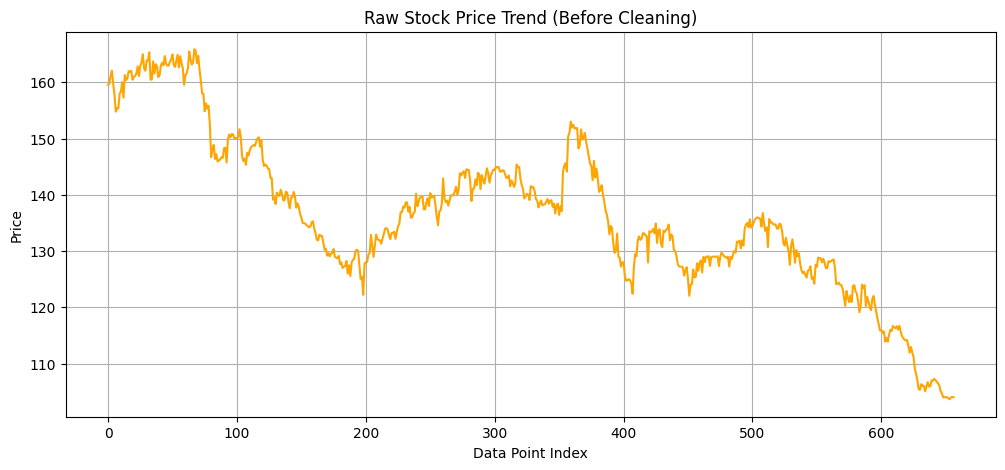

In [6]:
import matplotlib.pyplot as plt

# Plotting the raw Price column
plt.figure(figsize=(12, 5))
plt.plot(df['Price'], color='orange')
plt.title('Raw Stock Price Trend (Before Cleaning)')
plt.ylabel('Price')
plt.xlabel('Data Point Index')
plt.grid(True)
plt.show()

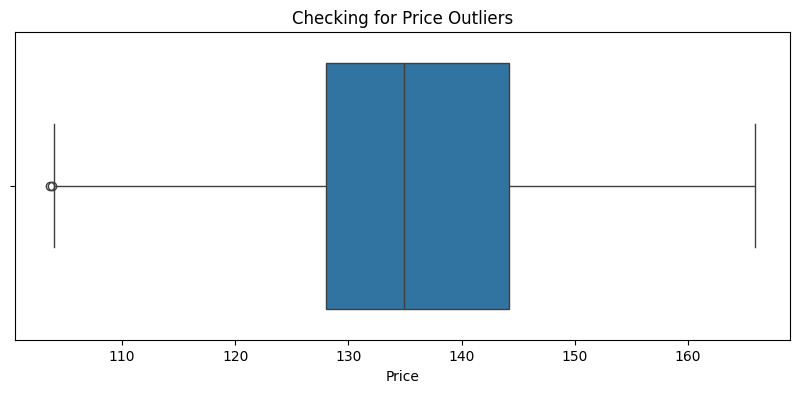

In [7]:
import seaborn as sns

# Boxplot to find outliers in Price and Volume
plt.figure(figsize=(10, 4))
sns.boxplot(x=df['Price'])
plt.title('Checking for Price Outliers')
plt.show()

In [8]:
# Print exact column names to check for hidden spaces
print(f"Exact Column Names: {df.columns.tolist()}")

Exact Column Names: ['Date', 'Price', 'Open', 'High', 'Low', 'Volume', 'Change(%)']


In [9]:
# Convert Date column to datetime objects
df['Date'] = pd.to_datetime(df['Date'])

# Clean Change(%) column: remove '%' and convert to float
df['Change(%)'] = df['Change(%)'].str.replace('%', '').astype(float)

# Sort by Date (ascending) so the model learns chronologically
df = df.sort_values('Date').reset_index(drop=True)

print("Data cleaning complete. Data sorted by date.")

Data cleaning complete. Data sorted by date.


In [10]:
# Create the target variable: Tomorrow's Price
df['Next_Price'] = df['Price'].shift(-1)

# Drop the last row because it won't have a "Next_Price" value
df = df.dropna()

# Define features (X) and target (y)
# We use today's Price, Open, High, Low, Volume, and Change to predict tomorrow's Price
features = ['Price', 'Open', 'High', 'Low', 'Volume', 'Change(%)']
X = df[features]
y = df['Next_Price']

print(f"Features selected: {features}")

Features selected: ['Price', 'Open', 'High', 'Low', 'Volume', 'Change(%)']


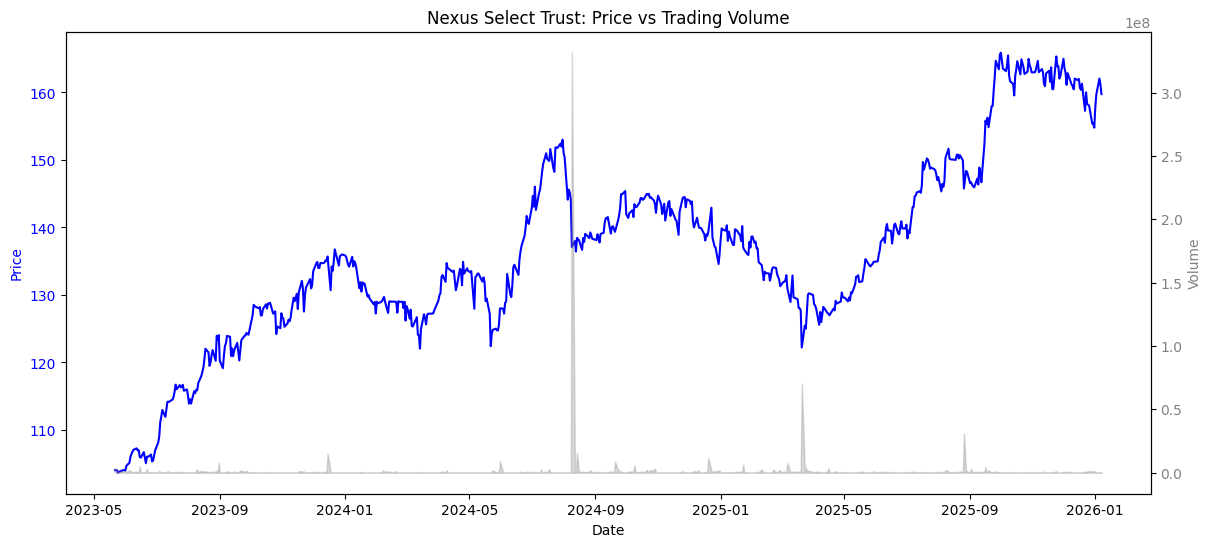

In [11]:
import matplotlib.pyplot as plt

# Plotting Price and Volume together to see their relationship
fig, ax1 = plt.subplots(figsize=(14, 6))

ax1.set_xlabel('Date')
ax1.set_ylabel('Price', color='blue')
ax1.plot(df['Date'], df['Price'], color='blue', label='Price')
ax1.tick_params(axis='y', labelcolor='blue')

ax2 = ax1.twinx()  # Create a second y-axis for Volume
ax2.set_ylabel('Volume', color='gray')
ax2.fill_between(df['Date'], df['Volume'], color='gray', alpha=0.3, label='Volume')
ax2.tick_params(axis='y', labelcolor='gray')

plt.title('Nexus Select Trust: Price vs Trading Volume')
plt.show()

In [12]:
from statsmodels.tsa.stattools import adfuller

# Run the Augmented Dickey-Fuller test
result = adfuller(df['Price'])
print(f'ADF Statistic: {result[0]}')
print(f'p-value: {result[1]}')

if result[1] > 0.05:
    print("Conclusion: Data is non-stationary. You will likely need to use 'Price Change' or 'Log Returns' instead of raw Price.")
else:
    print("Conclusion: Data is stationary.")

ADF Statistic: -1.695971334528597
p-value: 0.43318935280139187
Conclusion: Data is non-stationary. You will likely need to use 'Price Change' or 'Log Returns' instead of raw Price.


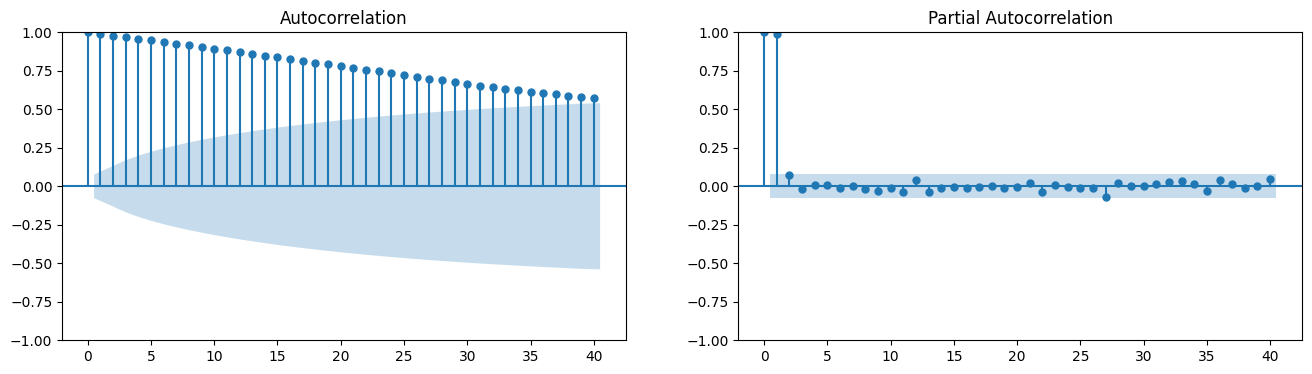

In [13]:
import statsmodels.api as sm

fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(16, 4))

sm.graphics.tsa.plot_acf(df['Price'], lags=40, ax=ax1)
sm.graphics.tsa.plot_pacf(df['Price'], lags=40, ax=ax2)

plt.show()

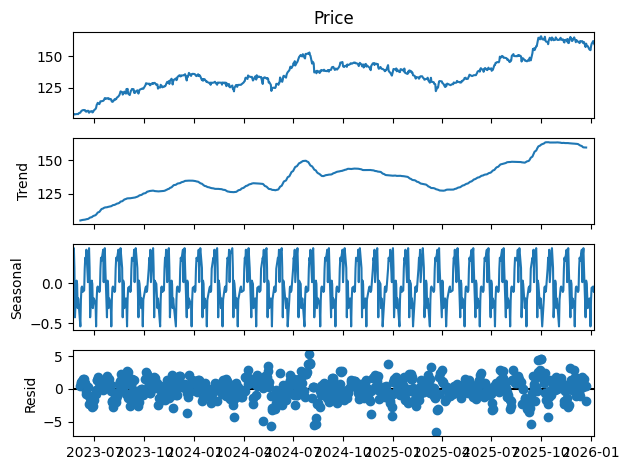

In [14]:
from statsmodels.tsa.seasonal import seasonal_decompose

# Set Date as index for decomposition
df_temp = df.set_index('Date')
# Assuming business days (freq=5) or monthly (freq=20)
decomposition = seasonal_decompose(df_temp['Price'], model='additive', period=20)

decomposition.plot()
plt.show()

In [15]:
# --- Final Sanity Check: Outlier Capping ---
def handle_outliers(df, column):
    Q1 = df[column].quantile(0.25)
    Q3 = df[column].quantile(0.75)
    IQR = Q3 - Q1
    lower_bound = Q1 - 1.5 * IQR
    upper_bound = Q3 + 1.5 * IQR

    # Instead of deleting, we "cap" the outliers to the bounds
    df[column] = df[column].clip(lower=lower_bound, upper=upper_bound)
    return df

# Apply to Price and Volume
df = handle_outliers(df, 'Price')
df = handle_outliers(df, 'Volume')

print("Final Sanity Check Complete: Outliers capped to 1.5x IQR.")
print("You are now 100% ready for Feature Engineering.")

Final Sanity Check Complete: Outliers capped to 1.5x IQR.
You are now 100% ready for Feature Engineering.


In [16]:
import pandas as pd
import numpy as np

# --- 1. Moving Averages (Trend) ---
# Short-term trend (5 days)
df['SMA_5'] = df['Price'].rolling(window=5).mean()
# Medium-term trend (20 days)
df['SMA_20'] = df['Price'].rolling(window=20).mean()
# Exponential trend (reacts faster)
df['EMA_10'] = df['Price'].ewm(span=10, adjust=False).mean()

# --- 2. Lag Features (Historical Context) ---
# Previous 3 days of prices
df['Lag_1'] = df['Price'].shift(1)
df['Lag_2'] = df['Price'].shift(2)
df['Lag_3'] = df['Price'].shift(3)

# --- 3. Volatility & Returns ---
# How much the price is 'vibrating'
df['Rolling_Std_7'] = df['Price'].rolling(window=7).std()
# Daily return (percentage change)
df['Daily_Return'] = df['Price'].pct_change()

# --- 4. Date Features ---
df['Day_of_Week'] = df['Date'].dt.dayofweek
df['Is_Month_End'] = df['Date'].dt.is_month_end.astype(int)

# --- 5. Creating the Target (Tomorrow's Price) ---
# This is what we want the model to predict
df['Target_Next_Day_Price'] = df['Price'].shift(-1)

# --- 6. Clean Up ---
# Rolling windows and Lags create "NaN" (empty) values at the start
# and the Target shift creates one NaN at the very end.
df_engineered = df.dropna().copy()

print(f"Original columns: 7")
print(f"New engineered columns: {len(df_engineered.columns)}")
print("\nFirst 5 rows of engineered features:")
print(df_engineered[['Date', 'Price', 'SMA_5', 'Lag_1', 'Target_Next_Day_Price']].head())

Original columns: 7
New engineered columns: 19

First 5 rows of engineered features:
         Date   Price    SMA_5   Lag_1  Target_Next_Day_Price
19 2023-06-16  105.88  106.616  105.99                 106.70
20 2023-06-19  106.70  106.504  105.88                 105.90
21 2023-06-20  105.90  106.292  106.70                 105.06
22 2023-06-21  105.06  105.906  105.90                 106.02
23 2023-06-22  106.02  105.912  105.06                 106.00


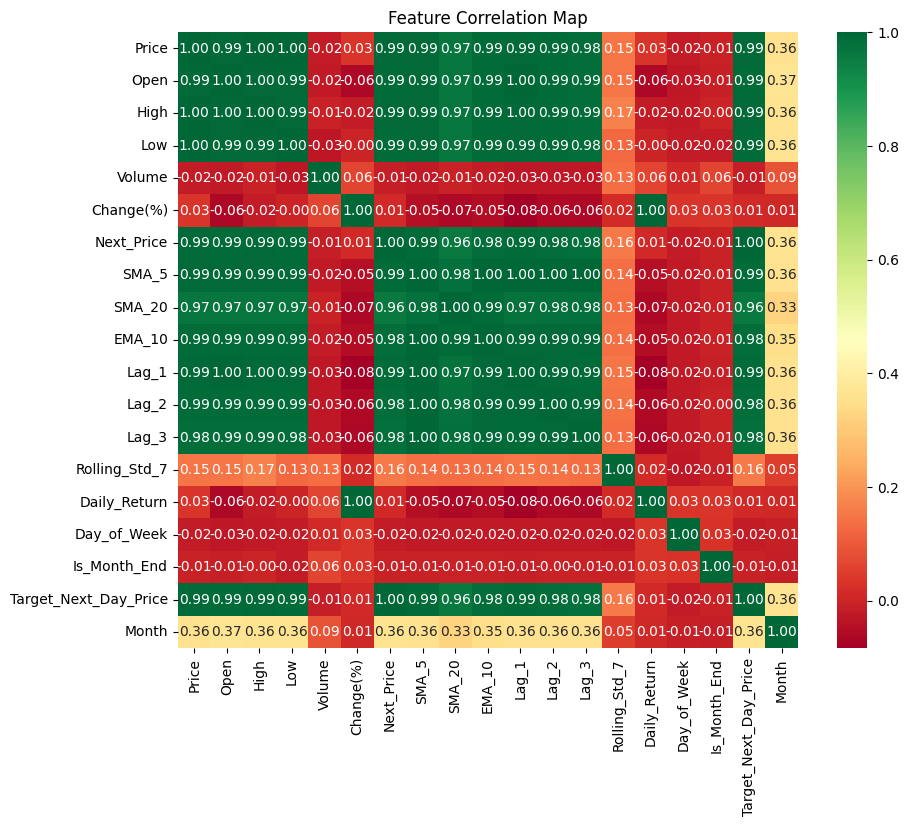

Pre-processing complete. Your data is now optimized for the Model Training step.


In [17]:
import seaborn as sns
from sklearn.preprocessing import StandardScaler

# --- 1. Technical Indicators & Lag Features ---
# Simple Moving Averages
df['SMA_5'] = df['Price'].rolling(window=5).mean()
df['SMA_20'] = df['Price'].rolling(window=20).mean()

# Lagged Prices (Price from 1, 2, and 3 days ago)
df['Lag_1'] = df['Price'].shift(1)
df['Lag_2'] = df['Price'].shift(2)
df['Lag_3'] = df['Price'].shift(3)

# Temporal Features
df['Day_of_Week'] = df['Date'].dt.dayofweek
df['Month'] = df['Date'].dt.month

# --- 2. Handle Missing Values ---
# Rolling windows and lags create NaN values at the start of the data. We must drop them.
df_final = df.dropna().copy()

# --- 3. Correlation Analysis (Visualization) ---
plt.figure(figsize=(10, 8))
# Drop non-numeric Date for correlation
corr = df_final.drop(columns=['Date']).corr()
sns.heatmap(corr, annot=True, cmap='RdYlGn', fmt=".2f")
plt.title("Feature Correlation Map")
plt.show()

# --- 4. Feature Scaling ---
# We scale features to have a mean of 0 and variance of 1
scaler = StandardScaler()
feature_cols = ['Price', 'Open', 'High', 'Low', 'Volume', 'Change(%)',
                'SMA_5', 'SMA_20', 'Lag_1', 'Lag_2', 'Lag_3']

# We fit the scaler on the features
df_final[feature_cols] = scaler.fit_transform(df_final[feature_cols])

print("Pre-processing complete. Your data is now optimized for the Model Training step.")

In [18]:
# 1. Define the Target variable first (if not already done)
df_final['Target'] = df_final['Price'].shift(-1)
df_final = df_final.dropna() # Drop the very last row created by the shift

# 2. Drop features that are too highly correlated with each other
# (Keep one, drop the other to reduce noise)
# We use the correlation matrix you just created.
corr_matrix = df_final[feature_cols].corr().abs()

# Select upper triangle of correlation matrix
upper = corr_matrix.where(np.triu(np.ones(corr_matrix.shape), k=1).astype(bool))

# Find features with correlation greater than 0.95
to_drop = [column for column in upper.columns if any(upper[column] > 0.95)]

print(f"Dropping redundant features: {to_drop}")
X_selected = df_final[feature_cols].drop(columns=to_drop)

# Update our feature list
selected_features = X_selected.columns.tolist()
print(f"Final features for training: {selected_features}")

Dropping redundant features: ['Open', 'High', 'Low', 'SMA_5', 'SMA_20', 'Lag_1', 'Lag_2', 'Lag_3']
Final features for training: ['Price', 'Volume', 'Change(%)']


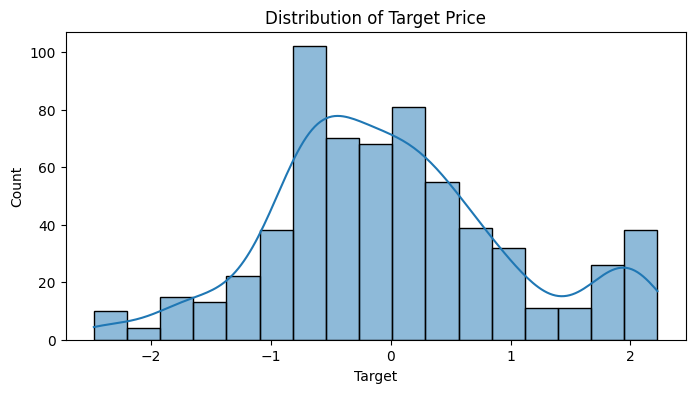

/usr/local/lib/python3.12/dist-packages/pandas/core/arraylike.py:399: RuntimeWarning: invalid value encountered in log1p
  result = getattr(ufunc, method)(*inputs, **kwargs)


In [19]:
import seaborn as sns

# Check the distribution of the Target Price
plt.figure(figsize=(8, 4))
sns.histplot(df_final['Target'], kde=True)
plt.title("Distribution of Target Price")
plt.show()

# If the data is heavily skewed, you can apply log transformation:
df_final['Target_Log'] = np.log1p(df_final['Target'])
# Note: If you do this, you must use np.expm1() on your predictions later to get back to real currency.

In [20]:
# Use the selected features from Step 1
X = df_final[selected_features]
y = df_final['Target']

# Sequential Split (75% training, 25% testing)
split_idx = int(len(df_final) * 0.75)

X_train, X_test = X.iloc[:split_idx], X.iloc[split_idx:]
y_train, y_test = y.iloc[:split_idx], y.iloc[split_idx:]

# Extract dates for the test set to ensure alignment with y_test
test_dates = df_final['Date'].iloc[split_idx:].reset_index(drop=True)

print(f"Training set size: {len(X_train)}")
print(f"Testing set size: {len(X_test)}")
print("Ready for Model Training.")

Training set size: 476
Testing set size: 159
Ready for Model Training.


In [21]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import xgboost as xg
from sklearn.ensemble import RandomForestRegressor
from sklearn.svm import SVR
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score

# Reshape X_train, X_test, y_train, y_test to 2D for features and 1D for target
# This is necessary if they were previously reshaped for a 3D input (e.g., for LSTM)
X_train = X_train.squeeze()
X_test = X_test.squeeze()
y_train = y_train.ravel()
y_test = y_test.ravel()

# 1. Initialize the models
models = {
    "Random Forest": RandomForestRegressor(n_estimators=100, random_state=42),
    "XGBoost": xg.XGBRegressor(n_estimators=100, learning_rate=0.05, max_depth=5, random_state=42),
    "SVR (RBF Kernel)": SVR(kernel='rbf', C=100, gamma=0.1, epsilon=.1)
}

# 2. Dictionary to store results
results_list = []
predictions_dict = {}

# 3. Loop through each model, train, and evaluate
print("--- Training and Evaluating Models ---")
for name, model in models.items():
    # Train
    model.fit(X_train, y_train)

    # Predict
    preds = model.predict(X_test)
    predictions_dict[name] = preds

    # Calculate Metrics
    mae = mean_absolute_error(y_test, preds)
    rmse = np.sqrt(mean_squared_error(y_test, preds))
    r2 = r2_score(y_test, preds)

    results_list.append({
        "Model": name,
        "MAE (₹)": round(mae, 3),
        "RMSE": round(rmse, 3),
        "R2 Score": round(r2, 4)
    })
    print(f"Finished: {name}")

# 4. Display the Comparison Table
comparison_df = pd.DataFrame(results_list).sort_values(by="MAE (₹)")
print("\n--- Final Performance Comparison ---")
print(comparison_df)

/tmp/ipython-input-4005599244.py:13: FutureWarning: Series.ravel is deprecated. The underlying array is already 1D, so ravel is not necessary.  Use `to_numpy()` for conversion to a numpy array instead.
  y_train = y_train.ravel()
/tmp/ipython-input-4005599244.py:14: FutureWarning: Series.ravel is deprecated. The underlying array is already 1D, so ravel is not necessary.  Use `to_numpy()` for conversion to a numpy array instead.
  y_test = y_test.ravel()


--- Training and Evaluating Models ---
Finished: Random Forest
Finished: XGBoost
Finished: SVR (RBF Kernel)

--- Final Performance Comparison ---
              Model  MAE (₹)   RMSE  R2 Score
2  SVR (RBF Kernel)    0.241  0.356    0.7840
0     Random Forest    0.438  0.579    0.4309
1           XGBoost    0.467  0.629    0.3273


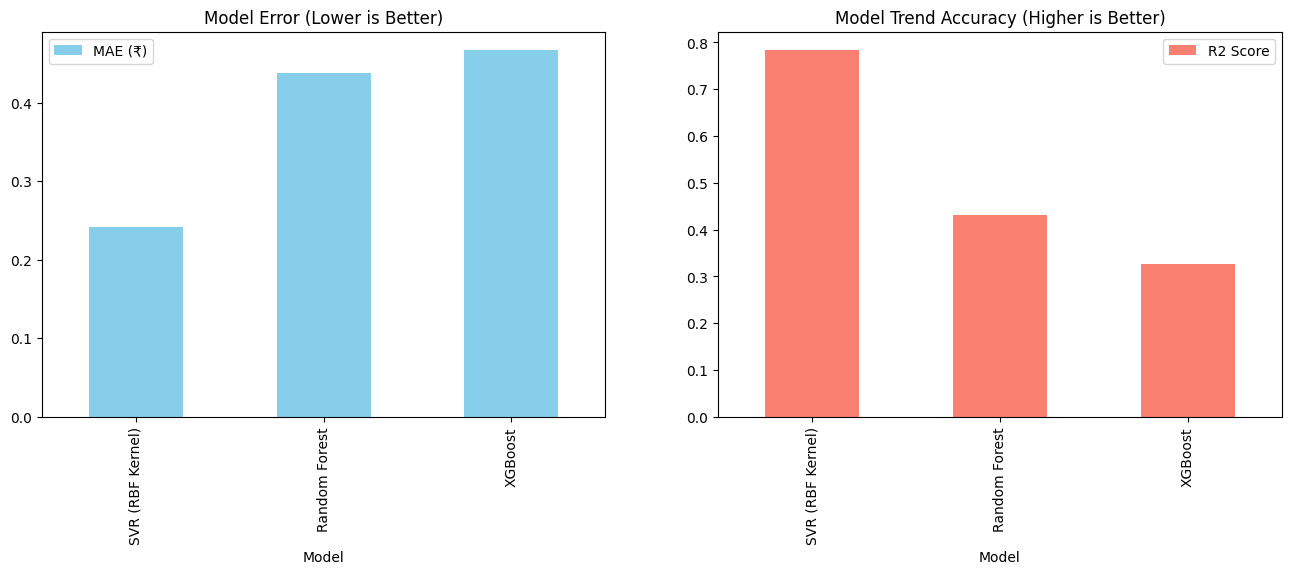

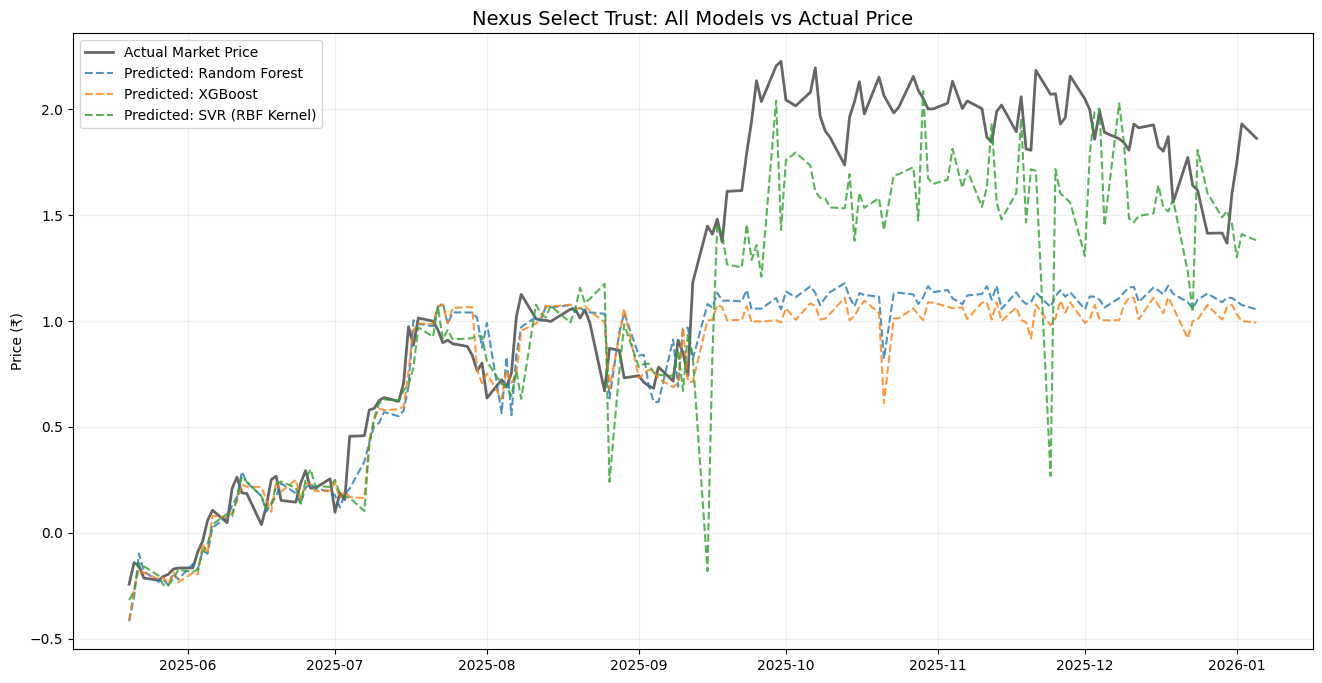

In [22]:
# --- Visualization 1: Error Comparison ---
fig, ax = plt.subplots(1, 2, figsize=(16, 5))

comparison_df.plot(x='Model', y='MAE (₹)', kind='bar', ax=ax[0], color='skyblue', title='Model Error (Lower is Better)')
comparison_df.plot(x='Model', y='R2 Score', kind='bar', ax=ax[1], color='salmon', title='Model Trend Accuracy (Higher is Better)')
plt.show()

# --- Visualization 2: Prediction Comparison Chart ---

plt.figure(figsize=(16, 8))
plt.plot(test_dates, y_test, label='Actual Market Price', color='black', linewidth=2, alpha=0.6)

colors = ['orange', 'green', 'red']
for (name, preds), color in zip(predictions_dict.items(), colors):
    plt.plot(test_dates, preds, label=f'Predicted: {name}', linestyle='--', alpha=0.8)

plt.title('Nexus Select Trust: All Models vs Actual Price', fontsize=14)
plt.ylabel('Price (₹)')
plt.legend()
plt.grid(True, alpha=0.2)
plt.show()

In [23]:
# Get latest data point
latest_data = X.tail(1).values

# Get prediction from all three
final_forecasts = {name: model.predict(latest_data)[0] for name, model in models.items()}

print("\n--- NEXT SESSION PRICE FORECASTS ---")
for name, price in final_forecasts.items():
    print(f"{name}: ₹{price:.2f}")

# Average of all three
ensemble_price = np.mean(list(final_forecasts.values()))
print(f"\nConsensus (Ensemble) Prediction: ₹{ensemble_price:.2f}")


--- NEXT SESSION PRICE FORECASTS ---
Random Forest: ₹1.06
XGBoost: ₹0.99
SVR (RBF Kernel): ₹1.38

Consensus (Ensemble) Prediction: ₹1.14


/usr/local/lib/python3.12/dist-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but RandomForestRegressor was fitted with feature names
  warnings.warn(
/usr/local/lib/python3.12/dist-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but SVR was fitted with feature names
  warnings.warn(


In [24]:
pip install eli5

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 108.4/108.4 kB 4.1 MB/s eta 0:00:00


In [25]:
import eli5
from eli5.sklearn import PermutationImportance

# Get the trained SVR model
svr_model = models["SVR (RBF Kernel)"]

# Initialize PermutationImportance
perm_importance = PermutationImportance(svr_model, random_state=42)

# Fit on the test data to calculate importance
perm_importance.fit(X_test, y_test)

# Display the feature importance
print("\n--- Permutation Feature Importance for SVR ---")
eli5.show_weights(perm_importance, feature_names=X_test.columns.tolist())


--- Permutation Feature Importance for SVR ---


Weight,Feature
1.5707 ± 0.2236,Price
-0.0401 ± 0.0213,Volume
-0.0498 ± 0.0220,Change(%)


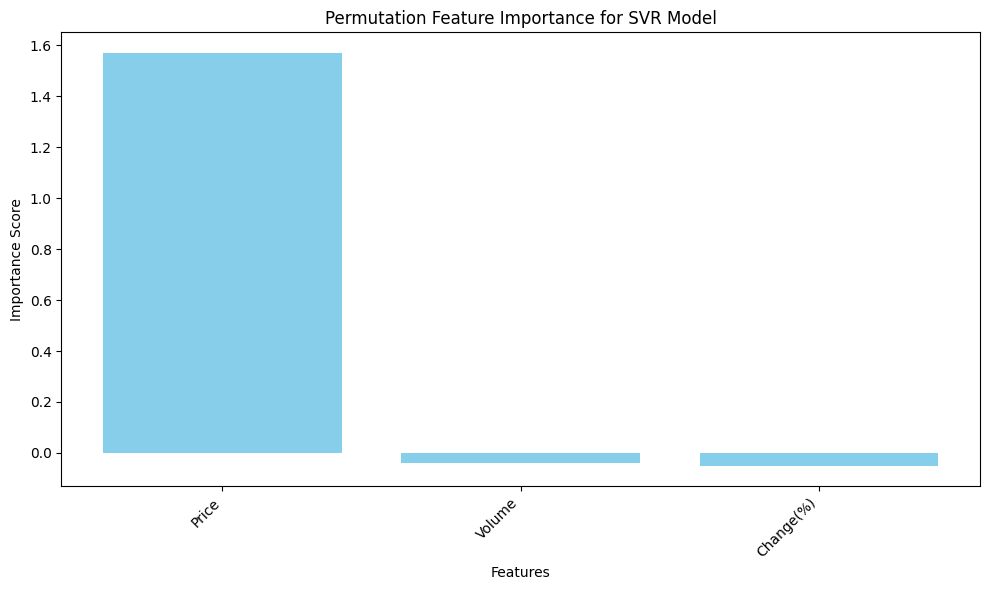

In [26]:
import matplotlib.pyplot as plt

# Extract feature names and their importance scores
feature_names = X_test.columns.tolist()
importance_scores = perm_importance.feature_importances_

# Create a DataFrame for easier plotting and sorting
feature_importance_df = pd.DataFrame({
    'Feature': feature_names,
    'Importance': importance_scores
}).sort_values(by='Importance', ascending=False)

# Create the bar plot
plt.figure(figsize=(10, 6))
plt.bar(feature_importance_df['Feature'], feature_importance_df['Importance'], color='skyblue')
plt.xlabel('Features')
plt.ylabel('Importance Score')
plt.title('Permutation Feature Importance for SVR Model')
plt.xticks(rotation=45, ha='right')
plt.tight_layout()
plt.show()

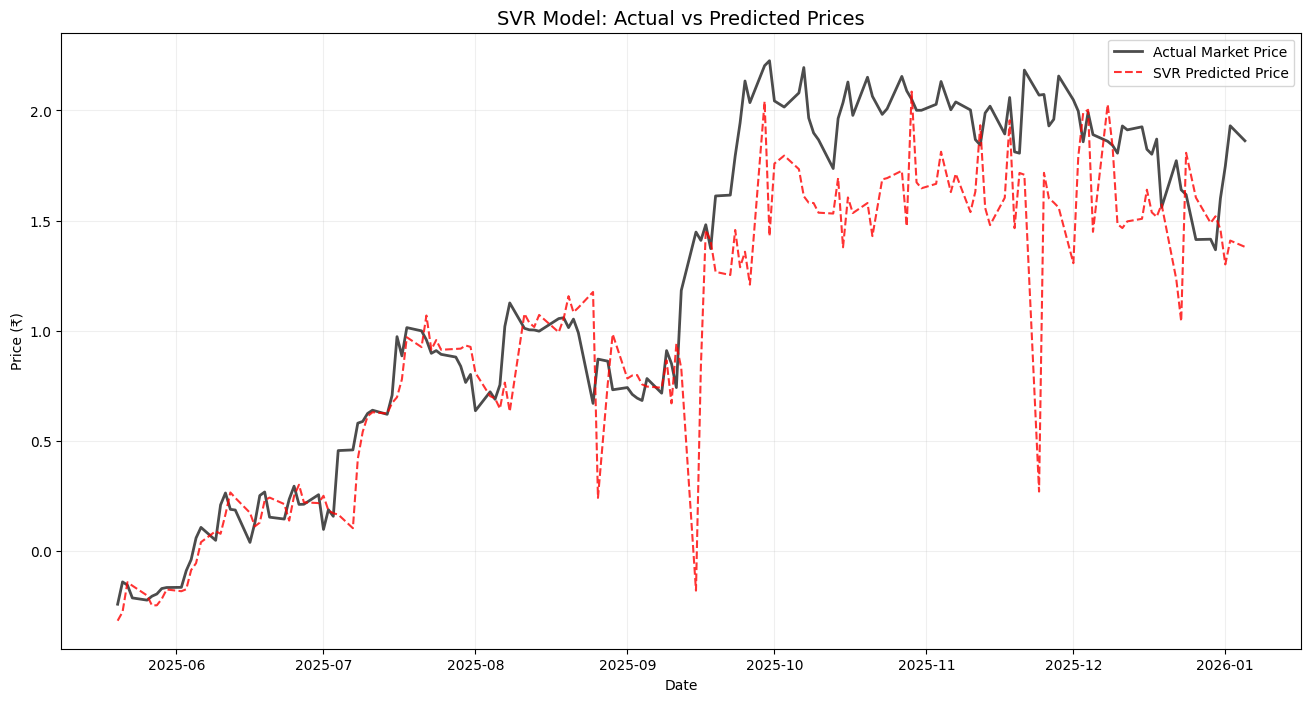

In [27]:
import matplotlib.pyplot as plt

# Get SVR predictions
svr_preds = predictions_dict['SVR (RBF Kernel)']

plt.figure(figsize=(16, 8))
plt.plot(test_dates, y_test, label='Actual Market Price', color='black', linewidth=2, alpha=0.7)
plt.plot(test_dates, svr_preds, label='SVR Predicted Price', color='red', linestyle='--', alpha=0.8)

plt.title('SVR Model: Actual vs Predicted Prices', fontsize=14)
plt.xlabel('Date')
plt.ylabel('Price (₹)')
plt.legend()
plt.grid(True, alpha=0.2)
plt.show()

# Task
The current SVR model has a MAE of 0.241 and an R2 score of 0.784. To further enhance its performance, the next step involves optimizing the SVR model's hyperparameters using `GridSearchCV`. This process will systematically explore different combinations of `C`, `gamma`, and `epsilon` to identify the set that yields the best predictive accuracy, thereby potentially improving the model's ability to forecast market prices.
The subsequent steps will perform hyperparameter tuning to find optimal SVR parameters. These optimized parameters will be used to train and evaluate a new SVR model, which will then be compared to the previous SVR model. Finally, the predictions of the tuned SVR model will be visualized.

**Plan:**

*   **Define Hyperparameter Search Space**: Define the grid of hyperparameters (C, gamma, epsilon) and their potential values for the SVR model. We'll explore a reasonable range for each to find the optimal combination.
*   **Perform Hyperparameter Tuning (GridSearchCV)**: Use GridSearchCV with cross-validation to systematically search through the defined hyperparameter space and find the combination that yields the best performance (e.g., lowest Mean Absolute Error or highest R2 score) on the training data.
*   **Evaluate Tuned SVR Model**: Train a new SVR model using the best hyperparameters found from GridSearchCV. Evaluate its performance on the test set using MAE, RMSE, and R2 score to see if tuning improved the model.
*   **Visualize Tuned Model Predictions**: Plot the actual market prices against the predictions from the tuned SVR model on the test set to visually assess its improved fit.
*   **Final Task**: Summarize the results of the hyperparameter tuning for the SVR model, highlighting any improvements in performance compared to the untuned model. Discuss the impact of the optimal hyperparameters found.

I will start by defining the hyperparameter search space for the SVR model.
```python
from sklearn.model_selection import GridSearchCV

# Define the parameter grid for SVR
param_grid = {
    'C': [0.1, 1, 10, 100],  # Regularization parameter
    'gamma': [0.001, 0.01, 0.1, 1], # Kernel coefficient
    'epsilon': [0.01, 0.1, 0.2] # Epsilon-tube parameter
}

# Initialize the SVR model
svr = SVR(kernel='rbf')

print("Hyperparameter search space defined for SVR.")
print(param_grid)
```

## Define Hyperparameter Search Space

### Subtask:
Define the grid of hyperparameters (C, gamma, epsilon) and their potential values for the SVR model. We'll explore a reasonable range for each to find the optimal combination.


**Reasoning**:
To define the hyperparameter search space, I need to import GridSearchCV, specify the ranges for C, gamma, and epsilon in a dictionary, initialize the SVR model, and then print the defined parameter grid.



In [28]:
from sklearn.model_selection import GridSearchCV
from sklearn.svm import SVR

# 1. Define a dictionary named param_grid specifying the hyperparameter search space
param_grid = {
    'C': [0.1, 1, 10, 100, 1000],
    'gamma': [1, 0.1, 0.01, 0.001, 0.0001],
    'epsilon': [0.01, 0.1, 0.5, 1.0]
}

# 2. Initialize an SVR model
svr = SVR(kernel='rbf')

print("Hyperparameter search space (param_grid) defined:")
print(param_grid)
print("SVR model initialized.")

Hyperparameter search space (param_grid) defined:
{'C': [0.1, 1, 10, 100, 1000], 'gamma': [1, 0.1, 0.01, 0.001, 0.0001], 'epsilon': [0.01, 0.1, 0.5, 1.0]}
SVR model initialized.


**Reasoning**:
Now that the hyperparameter search space is defined, the next step is to perform hyperparameter tuning using GridSearchCV to find the optimal combination of C, gamma, and epsilon for the SVR model.



In [29]:
from sklearn.model_selection import GridSearchCV

# 1. Initialize GridSearchCV
# We'll use the 'neg_mean_absolute_error' scoring to find the best parameters,
# as the goal is often to minimize MAE for price prediction.
# verbose=2 will show progress during the search.
grid_search = GridSearchCV(svr, param_grid, cv=5, scoring='neg_mean_absolute_error', verbose=2, n_jobs=-1)

# 2. Fit GridSearchCV to the training data
# This will systematically search through all parameter combinations
print("Starting GridSearchCV to find optimal SVR hyperparameters...")
grid_search.fit(X_train, y_train)

# 3. Print the best parameters and the best score
print("\nGridSearchCV complete.")
print(f"Best parameters found: {grid_search.best_params_}")
print(f"Best MAE score (negative, so smaller magnitude is better): {grid_search.best_score_:.3f}")

# Store the best estimator for later use
best_svr_tuned = grid_search.best_estimator_
print("Best SVR model stored for evaluation.")

Starting GridSearchCV to find optimal SVR hyperparameters...
Fitting 5 folds for each of 100 candidates, totalling 500 fits

GridSearchCV complete.
Best parameters found: {'C': 100, 'epsilon': 0.01, 'gamma': 0.001}
Best MAE score (negative, so smaller magnitude is better): -0.082
Best SVR model stored for evaluation.


**Reasoning**:
With the hyperparameter tuning complete and the best SVR model identified, the next step is to evaluate this tuned model on the test data. This will involve making predictions and calculating standard regression metrics (MAE, RMSE, R2 score) to assess its performance and compare it to the previously untuned SVR model.



In [30]:
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
import numpy as np

# 1. Make predictions on the test set using the best tuned SVR model
tuned_svr_preds = best_svr_tuned.predict(X_test)

# 2. Calculate evaluation metrics for the tuned model
tuned_mae = mean_absolute_error(y_test, tuned_svr_preds)
tuned_rmse = np.sqrt(mean_squared_error(y_test, tuned_svr_preds))
tuned_r2 = r2_score(y_test, tuned_svr_preds)

# 3. Store these predictions and metrics
predictions_dict['SVR (Tuned)'] = tuned_svr_preds

# Update the results list with the tuned SVR's performance
results_list.append({
    "Model": "SVR (Tuned)",
    "MAE (₹)": round(tuned_mae, 3),
    "RMSE": round(tuned_rmse, 3),
    "R2 Score": round(tuned_r2, 4)
})

# Sort and display the updated comparison table
comparison_df = pd.DataFrame(results_list).sort_values(by="MAE (₹)")

print("--- Evaluation of Tuned SVR Model ---")
print(f"Tuned SVR MAE: {tuned_mae:.3f}")
print(f"Tuned SVR RMSE: {tuned_rmse:.3f}")
print(f"Tuned SVR R2 Score: {tuned_r2:.4f}")

print("\n--- Updated Performance Comparison ---")
print(comparison_df)


--- Evaluation of Tuned SVR Model ---
Tuned SVR MAE: 0.088
Tuned SVR RMSE: 0.122
Tuned SVR R2 Score: 0.9745

--- Updated Performance Comparison ---
              Model  MAE (₹)   RMSE  R2 Score
3       SVR (Tuned)    0.088  0.122    0.9745
2  SVR (RBF Kernel)    0.241  0.356    0.7840
0     Random Forest    0.438  0.579    0.4309
1           XGBoost    0.467  0.629    0.3273


**Reasoning**:
The next step is to visualize the predictions of the tuned SVR model against the actual market prices to visually assess its improved fit, as outlined in the plan.



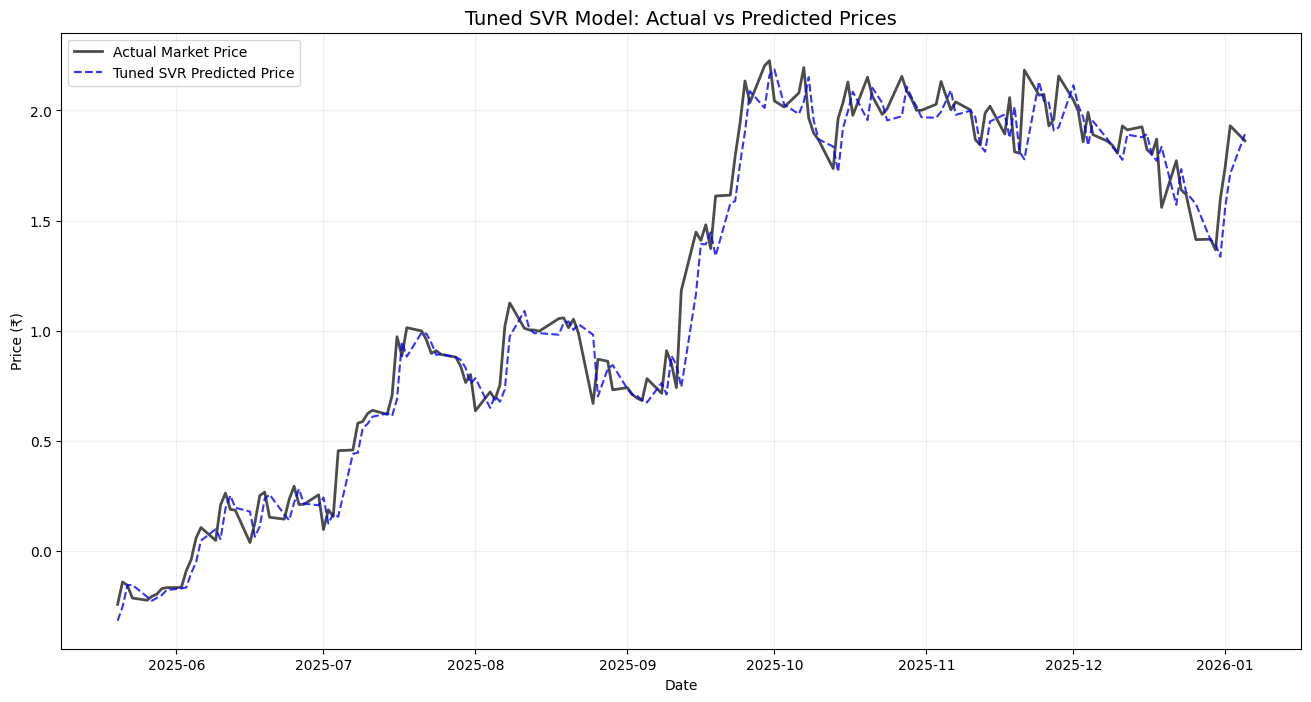

In [31]:
import matplotlib.pyplot as plt

# Get tuned SVR predictions
tuned_svr_preds = predictions_dict['SVR (Tuned)']

plt.figure(figsize=(16, 8))
plt.plot(test_dates, y_test, label='Actual Market Price', color='black', linewidth=2, alpha=0.7)
plt.plot(test_dates, tuned_svr_preds, label='Tuned SVR Predicted Price', color='blue', linestyle='--', alpha=0.8)

plt.title('Tuned SVR Model: Actual vs Predicted Prices', fontsize=14)
plt.xlabel('Date')
plt.ylabel('Price (₹)')
plt.legend()
plt.grid(True, alpha=0.2)
plt.show()

In [32]:
import pandas as pd
import numpy as np

# --- Helper Functions for Technical Indicators ---

def calculate_rsi(df, window=14):
    delta = df['Price'].diff()
    gain = (delta.where(delta > 0, 0)).rolling(window=window).mean()
    loss = (-delta.where(delta < 0, 0)).rolling(window=window).mean()
    rs = gain / loss
    rsi = 100 - (100 / (1 + rs))
    return rsi

def calculate_macd(df, fast_period=12, slow_period=26, signal_period=9):
    ema_fast = df['Price'].ewm(span=fast_period, adjust=False).mean()
    ema_slow = df['Price'].ewm(span=slow_period, adjust=False).mean()
    macd = ema_fast - ema_slow
    signal = macd.ewm(span=signal_period, adjust=False).mean()
    return macd, signal

def calculate_atr(df, window=14):
    high_low = df['High'] - df['Low']
    high_close = np.abs(df['High'] - df['Price'].shift())
    low_close = np.abs(df['Low'] - df['Price'].shift())
    tr = pd.concat([high_low, high_close, low_close], axis=1).max(axis=1)
    atr = tr.ewm(span=window, adjust=False).mean()
    return atr

def calculate_obv(df):
    obv = (np.sign(df['Price'].diff()) * df['Volume']).fillna(0).cumsum()
    return obv

# --- Generate New Features ---

# Use df_engineered as the base for new features, which contains unscaled data
# and initial engineered features. Make a copy to avoid modifying the original df_engineered.
df_new_features = df_engineered.copy()

# Momentum Indicators
df_new_features['RSI'] = calculate_rsi(df_new_features, window=14)
maci, signal = calculate_macd(df_new_features, fast_period=12, slow_period=26, signal_period=9)
df_new_features['MACD'] = maci
df_new_features['MACD_Signal'] = signal

# Volatility Indicators
df_new_features['ATR'] = calculate_atr(df_new_features, window=14)

# Bollinger Bands
window_bb = 20
num_std_dev = 2
df_new_features['MA_BB'] = df_new_features['Price'].rolling(window=window_bb).mean()
df_new_features['Upper_BB'] = df_new_features['MA_BB'] + (df_new_features['Price'].rolling(window=window_bb).std() * num_std_dev)
df_new_features['Lower_BB'] = df_new_features['MA_BB'] - (df_new_features['Price'].rolling(window=window_bb).std() * num_std_dev)
df_new_features['BB_Bandwidth'] = df_new_features['Upper_BB'] - df_new_features['Lower_BB']
df_new_features['BB_Percent_B'] = (df_new_features['Price'] - df_new_features['Lower_BB']) / (df_new_features['Upper_BB'] - df_new_features['Lower_BB'])

# Volume-based Indicators
df_new_features['OBV'] = calculate_obv(df_new_features)
df_new_features['VMA'] = df_new_features['Volume'].rolling(window=20).mean()

# --- Clean Up NaN values introduced by rolling window calculations ---
df_full_engineered = df_new_features.dropna().copy()

print("New features (RSI, MACD, ATR, Bollinger Bands, OBV, VMA) generated and added to the DataFrame.")
print(f"Original DataFrame shape (df_engineered): {df_engineered.shape}")
print(f"DataFrame shape after adding new features and dropping NaNs (df_full_engineered): {df_full_engineered.shape}")
print("First 5 rows of DataFrame with new features:")
print(df_full_engineered[['Date', 'Price', 'RSI', 'MACD', 'ATR', 'Upper_BB', 'OBV', 'VMA']].head())

New features (RSI, MACD, ATR, Bollinger Bands, OBV, VMA) generated and added to the DataFrame.
Original DataFrame shape (df_engineered): (636, 19)
DataFrame shape after adding new features and dropping NaNs (df_full_engineered): (617, 30)
First 5 rows of DataFrame with new features:
         Date   Price        RSI      MACD       ATR    Upper_BB         OBV  \
38 2023-07-14  114.21  83.185125  2.141887  2.075661  115.976313  3384128.25   
39 2023-07-17  114.50  83.116883  2.216135  2.013572  116.653432  3671065.25   
40 2023-07-18  114.88  90.924658  2.279365  1.958429  117.330032  4113530.25   
41 2023-07-19  115.69  91.423948  2.367544  1.895972  118.009199  4541964.25   
42 2023-07-20  116.70  91.069924  2.490220  2.083176  118.669435  4976789.25   

            VMA  
38  560160.2125  
39  561703.2625  
40  576087.6625  
41  588251.0625  
42  553649.4125  


## Re-evaluate Feature Correlation and Selection

### Subtask:
Re-run the correlation analysis to identify and potentially remove highly correlated or redundant features from the newly engineered dataset (`df_full_engineered`).


**Reasoning**:
To identify highly correlated features in the newly engineered dataset, I need to create and visualize a correlation matrix of all numeric columns in `df_full_engineered` using a heatmap.



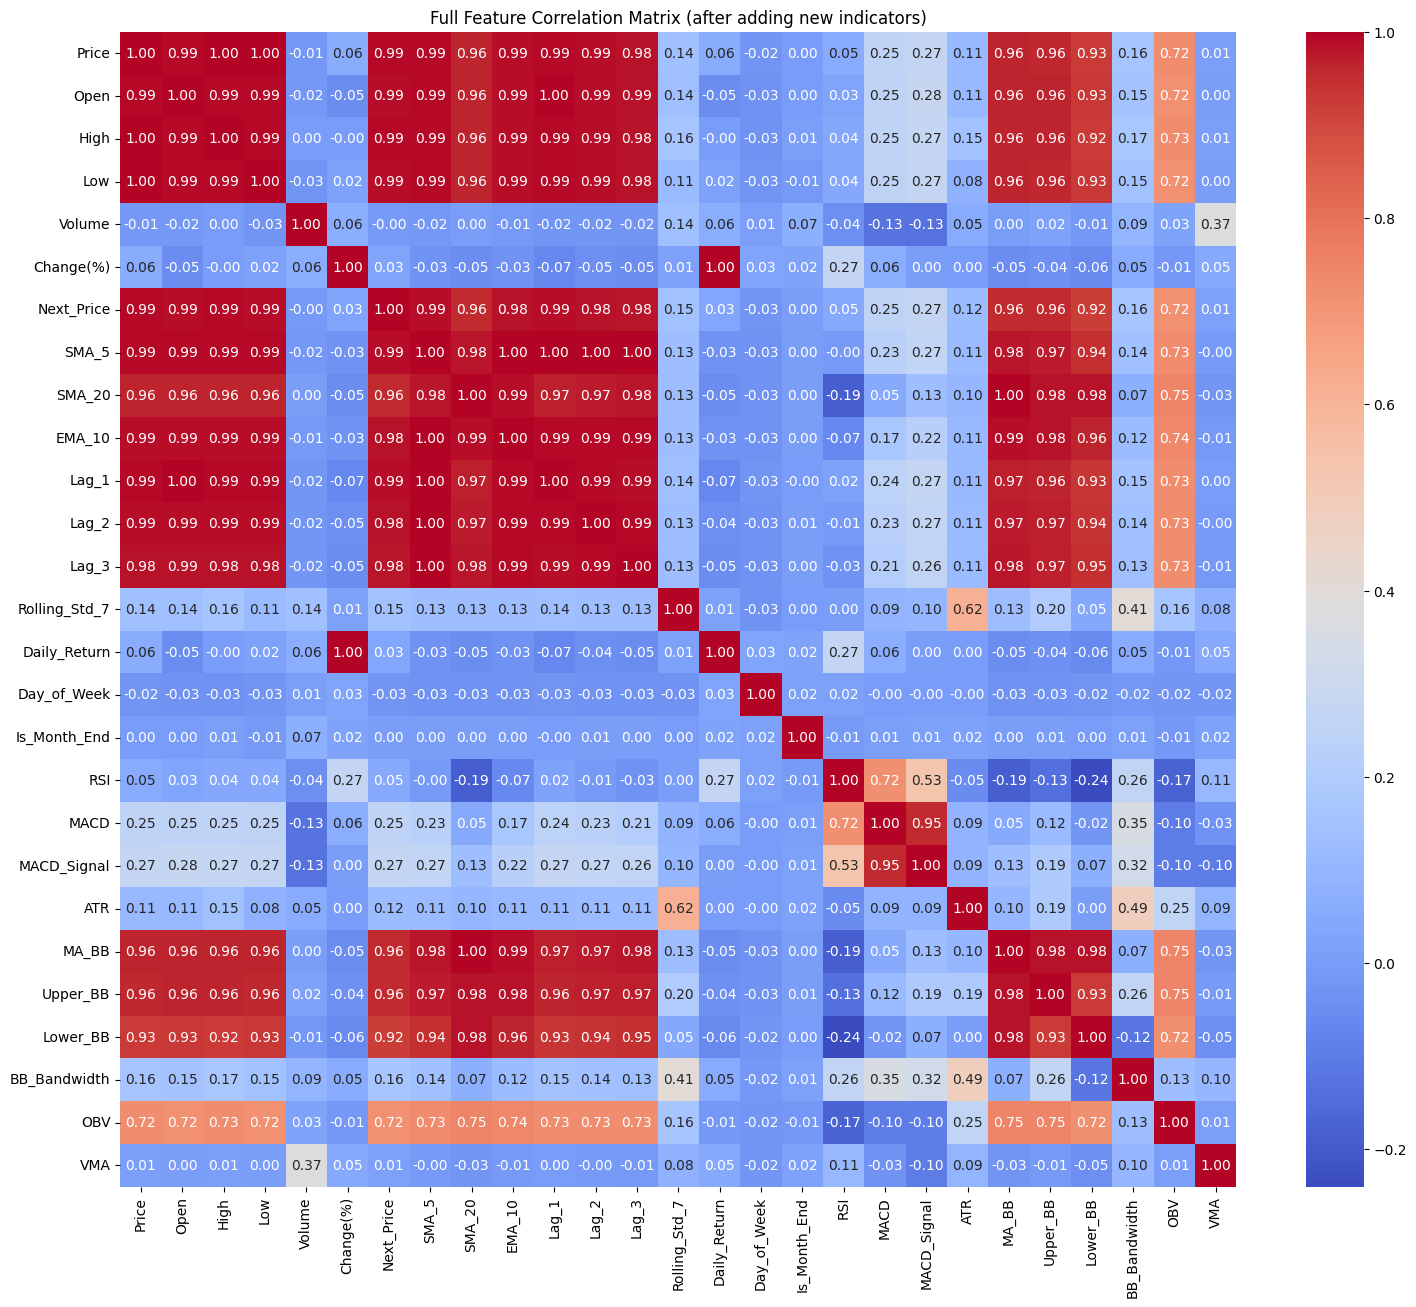

Correlation matrix created and visualized.


In [33]:
import seaborn as sns
import matplotlib.pyplot as plt

# Create a correlation matrix for all numeric columns in df_full_engineered
# Exclude 'Date' and 'Target_Next_Day_Price' as it's the target and should not be used for feature correlation here
# Also exclude 'BB_Percent_B' which often has NaN values or extreme values due to division by zero if Upper_BB == Lower_BB

numeric_cols_for_corr = df_full_engineered.select_dtypes(include=np.number).columns.tolist()

# Remove target and potentially problematic columns if they exist and are numeric
if 'Target_Next_Day_Price' in numeric_cols_for_corr:
    numeric_cols_for_corr.remove('Target_Next_Day_Price')
if 'BB_Percent_B' in numeric_cols_for_corr:
    numeric_cols_for_corr.remove('BB_Percent_B') # Remove if it's causing issues or is very skewed

corr_matrix_full = df_full_engineered[numeric_cols_for_corr].corr()

# Visualize the correlation matrix using a heatmap
plt.figure(figsize=(18, 15))
sns.heatmap(corr_matrix_full, annot=True, cmap='coolwarm', fmt=".2f")
plt.title("Full Feature Correlation Matrix (after adding new indicators)")
plt.show()

print("Correlation matrix created and visualized.")

**Reasoning**:
Now that the correlation matrix is visualized, I need to programmatically identify features that are highly correlated with each other (absolute correlation > 0.95), and then remove one from each pair to reduce multicollinearity and simplify the model, storing the remaining features in a new DataFrame.



In [34]:
import numpy as np

# Create a copy to work with for feature selection
df_selected_features = df_full_engineered.copy()

# Prepare the correlation matrix for the features we want to consider
# Exclude 'Target_Next_Day_Price' as it is the target variable
feature_cols_for_selection = [col for col in df_selected_features.select_dtypes(include=np.number).columns if col != 'Target_Next_Day_Price']

# Recalculate correlation matrix for relevant features
corr_matrix_features = df_selected_features[feature_cols_for_selection].corr().abs()

# Select upper triangle of correlation matrix
upper_tri = corr_matrix_features.where(np.triu(np.ones(corr_matrix_features.shape), k=1).astype(bool))

# Find features with correlation greater than 0.95
to_drop_high_corr = [column for column in upper_tri.columns if any(upper_tri[column] > 0.95)]

# Drop identified redundant features
df_selected_features = df_selected_features.drop(columns=to_drop_high_corr)

# Update the list of selected features
final_selected_features = [col for col in df_selected_features.columns if col not in ['Date', 'Target_Next_Day_Price']]

print(f"Dropped highly correlated features: {to_drop_high_corr}")
print(f"Final selected features for model training: {final_selected_features}")

Dropped highly correlated features: ['Open', 'High', 'Low', 'Next_Price', 'SMA_5', 'SMA_20', 'EMA_10', 'Lag_1', 'Lag_2', 'Lag_3', 'Daily_Return', 'MACD_Signal', 'MA_BB', 'Upper_BB', 'Lower_BB']
Final selected features for model training: ['Price', 'Volume', 'Change(%)', 'Rolling_Std_7', 'Day_of_Week', 'Is_Month_End', 'RSI', 'MACD', 'ATR', 'BB_Bandwidth', 'BB_Percent_B', 'OBV', 'VMA']


In [35]:
import pandas as pd

# 1. Define the target variable `y`
y = df_full_engineered['Target_Next_Day_Price']

# 2. Define the features `X` using the `final_selected_features`
X = df_full_engineered[final_selected_features]

# Perform a sequential split of the data into training and testing sets (75% training, 25% testing)
split_idx = int(len(df_full_engineered) * 0.75)

X_train, X_test = X.iloc[:split_idx], X.iloc[split_idx:]
y_train, y_test = y.iloc[:split_idx], y.iloc[split_idx:]

# Store the corresponding 'Date' column for the test set
test_dates = df_full_engineered['Date'].iloc[split_idx:].reset_index(drop=True)

print(f"Original dataset size: {len(df_full_engineered)}")
print(f"Training set size (X_train, y_train): {len(X_train)}")
print(f"Testing set size (X_test, y_test): {len(X_test)}")
print("Data re-split successfully, ready for model training.")

Original dataset size: 617
Training set size (X_train, y_train): 462
Testing set size (X_test, y_test): 155
Data re-split successfully, ready for model training.


In [36]:
import pandas as pd
import numpy as np
import xgboost as xg
from sklearn.ensemble import RandomForestRegressor
from sklearn.svm import SVR
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score

# Ensure X_train, X_test, y_train, y_test are 1D for targets and 2D for features
# (These might have been squeezed in a previous step, so re-verify shape if needed)
X_train_reshaped = X_train # Assuming X_train is already a DataFrame or can be directly used
X_test_reshaped = X_test   # Assuming X_test is already a DataFrame or can be directly used
y_train_reshaped = y_train.values.ravel() # Ensure y is 1D numpy array
y_test_reshaped = y_test.values.ravel()   # Ensure y is 1D numpy array

# 1. Initialize the models with new (or previously determined best) parameters
# SVR with best parameters from GridSearchCV:
best_svr_tuned_params = grid_search.best_params_
svr_tuned = SVR(kernel='rbf', **best_svr_tuned_params)

# Random Forest with previous parameters
rf_model = RandomForestRegressor(n_estimators=100, random_state=42)

# XGBoost with previous parameters
xgb_model = xg.XGBRegressor(n_estimators=100, learning_rate=0.05, max_depth=5, random_state=42)

models_updated = {
    "Random Forest (New Features)": rf_model,
    "XGBoost (New Features)": xgb_model,
    "SVR (Tuned, New Features)": svr_tuned
}

# 2. Dictionary to store new results and predictions
results_list_new = []
predictions_dict_new = {}

# 3. Loop through each model, train, and evaluate
print("--- Training and Evaluating Models with New Features ---")
for name, model in models_updated.items():
    # Train
    model.fit(X_train_reshaped, y_train_reshaped)

    # Predict
    preds = model.predict(X_test_reshaped)
    predictions_dict_new[name] = preds

    # Calculate Metrics
    mae = mean_absolute_error(y_test_reshaped, preds)
    rmse = np.sqrt(mean_squared_error(y_test_reshaped, preds))
    r2 = r2_score(y_test_reshaped, preds)

    results_list_new.append({
        "Model": name,
        "MAE (₹)": round(mae, 3),
        "RMSE": round(rmse, 3),
        "R2 Score": round(r2, 4)
    })
    print(f"Finished: {name}")

# 4. Display the Comparison Table
comparison_df_new = pd.DataFrame(results_list_new).sort_values(by="MAE (₹)")
print("\n--- Performance Comparison with New Features ---")
print(comparison_df_new)


--- Training and Evaluating Models with New Features ---
Finished: Random Forest (New Features)
Finished: XGBoost (New Features)
Finished: SVR (Tuned, New Features)

--- Performance Comparison with New Features ---
                          Model  MAE (₹)    RMSE  R2 Score
0  Random Forest (New Features)    6.734   8.821    0.1404
1        XGBoost (New Features)    8.400  10.810   -0.2910
2     SVR (Tuned, New Features)   20.034  22.178   -4.4345


In [37]:
from sklearn.preprocessing import StandardScaler
import pandas as pd

# 1. Initialize a StandardScaler object
scaler = StandardScaler()

# 2. Fit the scaler to X_train and transform both X_train and X_test
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

# 3. Convert the scaled NumPy arrays back into Pandas DataFrames
X_train_scaled = pd.DataFrame(X_train_scaled, columns=X_train.columns, index=X_train.index)
X_test_scaled = pd.DataFrame(X_test_scaled, columns=X_test.columns, index=X_test.index)

print("X_train_scaled head:")
print(X_train_scaled.head())
print("\nX_test_scaled head:")
print(X_test_scaled.head())
print("Data scaled successfully.")

X_train_scaled head:
       Price    Volume  Change(%)  Rolling_Std_7  Day_of_Week  Is_Month_End  \
38 -2.329559 -0.400704   0.024716      -0.488523     1.353738     -0.183186   
39 -2.293570 -0.471884   0.183310      -0.588727    -1.419774     -0.183186   
40 -2.246413 -0.137287   0.253796      -0.486049    -0.726396     -0.183186   
41 -2.145893 -0.167473   0.588605      -0.780277    -0.033018     -0.183186   
42 -2.020554 -0.153723   0.729577      -0.547895     0.660360     -0.183186   

         RSI      MACD       ATR  BB_Bandwidth  BB_Percent_B       OBV  \
38  1.943560  1.216091 -1.510921      1.158836      1.051500 -2.755367   
39  1.939172  1.266450 -1.598805      1.269255      0.981710 -2.724336   
40  2.441173  1.309336 -1.676859      1.389312      0.936806 -2.676487   
41  2.473275  1.369144 -1.765266      1.474405      0.975813 -2.630154   
42  2.450513  1.452348 -1.500283      1.509505      1.050531 -2.583131   

         VMA  
38  0.235606  
39  0.243019  
40  0.312126  

**Reasoning**:
Now that the features are scaled, I will re-train the models (tuned SVR, Random Forest, and XGBoost) using the scaled training data and evaluate their performance on the scaled test data to assess the impact of proper scaling on the new features.



In [38]:
import pandas as pd
import numpy as np
import xgboost as xg
from sklearn.ensemble import RandomForestRegressor
from sklearn.svm import SVR
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score

# Ensure y_train, y_test are 1D numpy arrays
y_train_reshaped = y_train.values.ravel() # Ensure y is 1D numpy array
y_test_reshaped = y_test.values.ravel()   # Ensure y is 1D numpy array

# 1. Initialize the models with new (or previously determined best) parameters
# SVR with best parameters from GridSearchCV:
best_svr_tuned_params = grid_search.best_params_
svr_tuned = SVR(kernel='rbf', **best_svr_tuned_params)

# Random Forest with previous parameters
rf_model = RandomForestRegressor(n_estimators=100, random_state=42)

# XGBoost with previous parameters
xgb_model = xg.XGBRegressor(n_estimators=100, learning_rate=0.05, max_depth=5, random_state=42)

models_updated = {
    "Random Forest (New Features, Scaled)": rf_model,
    "XGBoost (New Features, Scaled)": xgb_model,
    "SVR (Tuned, New Features, Scaled)": svr_tuned
}

# 2. Dictionary to store new results and predictions
results_list_new = []
predictions_dict_new = {}

# 3. Loop through each model, train, and evaluate
print("--- Training and Evaluating Models with New Features and Scaling ---")
for name, model in models_updated.items():
    # Train using scaled features
    model.fit(X_train_scaled, y_train_reshaped)

    # Predict using scaled features
    preds = model.predict(X_test_scaled)
    predictions_dict_new[name] = preds

    # Calculate Metrics
    mae = mean_absolute_error(y_test_reshaped, preds)
    rmse = np.sqrt(mean_squared_error(y_test_reshaped, preds))
    r2 = r2_score(y_test_reshaped, preds)

    results_list_new.append({
        "Model": name,
        "MAE (₹)": round(mae, 3),
        "RMSE": round(rmse, 3),
        "R2 Score": round(r2, 4)
    })
    print(f"Finished: {name}")

# 4. Display the Comparison Table
comparison_df_new = pd.DataFrame(results_list_new).sort_values(by="MAE (₹)")
print("\n--- Performance Comparison with New Features and Scaling ---")
print(comparison_df_new)


--- Training and Evaluating Models with New Features and Scaling ---
Finished: Random Forest (New Features, Scaled)
Finished: XGBoost (New Features, Scaled)
Finished: SVR (Tuned, New Features, Scaled)

--- Performance Comparison with New Features and Scaling ---
                                  Model  MAE (₹)    RMSE  R2 Score
2     SVR (Tuned, New Features, Scaled)    3.478   4.131    0.8114
0  Random Forest (New Features, Scaled)    6.733   8.821    0.1404
1        XGBoost (New Features, Scaled)    8.400  10.810   -0.2910


In [39]:
print("--- Performance Comparison with New Features and Scaling ---")
print(comparison_df_new)

# Identify the model with the lowest MAE
best_mae_model = comparison_df_new.loc[comparison_df_new['MAE (₹)'].idxmin()]
print(f"\nModel with the lowest MAE: {best_mae_model['Model']} (MAE: {best_mae_model['MAE (₹)']:.3f})")

# Identify the model with the highest R2 Score
best_r2_model = comparison_df_new.loc[comparison_df_new['R2 Score'].idxmax()]
print(f"Model with the highest R2 Score: {best_r2_model['Model']} (R2 Score: {best_r2_model['R2 Score']:.4f})")

--- Performance Comparison with New Features and Scaling ---
                                  Model  MAE (₹)    RMSE  R2 Score
2     SVR (Tuned, New Features, Scaled)    3.478   4.131    0.8114
0  Random Forest (New Features, Scaled)    6.733   8.821    0.1404
1        XGBoost (New Features, Scaled)    8.400  10.810   -0.2910

Model with the lowest MAE: SVR (Tuned, New Features, Scaled) (MAE: 3.478)
Model with the highest R2 Score: SVR (Tuned, New Features, Scaled) (R2 Score: 0.8114)


In [40]:
print("--- Comparing SVR Models ---")

# Retrieve metrics for SVR (Tuned, New Features, Scaled)
svr_tuned_new_features_metrics = comparison_df_new.loc[comparison_df_new['Model'] == 'SVR (Tuned, New Features, Scaled)'].iloc[0]
print(f"\nSVR (Tuned, New Features, Scaled):")
print(f"  MAE: {svr_tuned_new_features_metrics['MAE (₹)']:.3f}")
print(f"  R2 Score: {svr_tuned_new_features_metrics['R2 Score']:.4f}")

# Retrieve metrics for SVR (Tuned, original features) from the previous comparison_df
# Ensure 'SVR (Tuned)' is correctly identified from the previous run
svr_tuned_original_features_metrics = comparison_df.loc[comparison_df['Model'] == 'SVR (Tuned)'].iloc[0]
print(f"\nSVR (Tuned, Original Features):")
print(f"  MAE: {svr_tuned_original_features_metrics['MAE (₹)']:.3f}")
print(f"  R2 Score: {svr_tuned_original_features_metrics['R2 Score']:.4f}")

--- Comparing SVR Models ---

SVR (Tuned, New Features, Scaled):
  MAE: 3.478
  R2 Score: 0.8114

SVR (Tuned, Original Features):
  MAE: 0.088
  R2 Score: 0.9745


In [41]:
from sklearn.model_selection import GridSearchCV
from sklearn.svm import SVR # Import SVR here

# Define a new, refined parameter grid for SVR, centered around previous bests
param_grid_refined = {
    'C': [50, 100, 150, 200],  # Centered around 100
    'gamma': [0.0005, 0.001, 0.002, 0.005], # Centered around 0.001
    'epsilon': [0.005, 0.01, 0.015, 0.02] # Centered around 0.01
}

# Initialize the SVR model (kernel remains 'rbf')
svr_refined = SVR(kernel='rbf')

# 1. Initialize GridSearchCV with the refined parameter grid
# Use the svr_refined model (initialized here)
grid_search_refined = GridSearchCV(svr_refined, param_grid_refined, cv=5, scoring='neg_mean_absolute_error', verbose=2, n_jobs=-1)

# 2. Fit GridSearchCV to the scaled training data (X_train_scaled, y_train_reshaped)
print("Starting extensive GridSearchCV to find optimal SVR hyperparameters...")
grid_search_refined.fit(X_train_scaled, y_train_reshaped)

# 3. Print the best parameters and the best score
print("\nExtensive GridSearchCV complete.")
print(f"Best parameters found from refined search: {grid_search_refined.best_params_}")
print(f"Best MAE score (negative) from refined search: {grid_search_refined.best_score_:.3f}")

# Store the best estimator for later use
best_svr_extensively_tuned = grid_search_refined.best_estimator_
print("Best SVR model from extensive tuning stored for evaluation.")

Starting extensive GridSearchCV to find optimal SVR hyperparameters...
Fitting 5 folds for each of 64 candidates, totalling 320 fits

Extensive GridSearchCV complete.
Best parameters found from refined search: {'C': 200, 'epsilon': 0.01, 'gamma': 0.001}
Best MAE score (negative) from refined search: -1.243
Best SVR model from extensive tuning stored for evaluation.


In [42]:
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
import numpy as np
import pandas as pd

# 1. Make predictions on the scaled test set using the best extensively tuned SVR model
extensively_tuned_svr_preds = best_svr_extensively_tuned.predict(X_test_scaled)

# 2. Calculate evaluation metrics for the extensively tuned model
extensively_tuned_mae = mean_absolute_error(y_test_reshaped, extensively_tuned_svr_preds)
extensively_tuned_rmse = np.sqrt(mean_squared_error(y_test_reshaped, extensively_tuned_svr_preds))
extensively_tuned_r2 = r2_score(y_test_reshaped, extensively_tuned_svr_preds)

# 3. Store these predictions and metrics
predictions_dict_new['SVR (Extensively Tuned, New Features, Scaled)'] = extensively_tuned_svr_preds

# Add the extensively tuned SVR's performance to the results list
model_name = "SVR (Extensively Tuned, New Features, Scaled)"
found = False
for i, item in enumerate(results_list_new):
    if item["Model"] == model_name:
        results_list_new[i] = {
            "Model": model_name,
            "MAE (₹)": round(extensively_tuned_mae, 3),
            "RMSE": round(extensively_tuned_rmse, 3),
            "R2 Score": round(extensively_tuned_r2, 4)
        }
        found = True
        break
if not found:
    results_list_new.append({
        "Model": model_name,
        "MAE (₹)": round(extensively_tuned_mae, 3),
        "RMSE": round(extensively_tuned_rmse, 3),
        "R2 Score": round(extensively_tuned_r2, 4)
    })

# Sort and display the updated comparison table
comparison_df_new = pd.DataFrame(results_list_new).sort_values(by="MAE (₹)")

print("--- Evaluation of Extensively Tuned SVR Model ---")
print(f"Extensively Tuned SVR MAE: {extensively_tuned_mae:.3f}")
print(f"Extensively Tuned SVR RMSE: {extensively_tuned_rmse:.3f}")
print(f"Extensively Tuned SVR R2 Score: {extensively_tuned_r2:.4f}")

print("\n--- Updated Performance Comparison ---")
print(comparison_df_new)

--- Evaluation of Extensively Tuned SVR Model ---
Extensively Tuned SVR MAE: 2.571
Extensively Tuned SVR RMSE: 3.180
Extensively Tuned SVR R2 Score: 0.8883

--- Updated Performance Comparison ---
                                           Model  MAE (₹)    RMSE  R2 Score
3  SVR (Extensively Tuned, New Features, Scaled)    2.571   3.180    0.8883
2              SVR (Tuned, New Features, Scaled)    3.478   4.131    0.8114
0           Random Forest (New Features, Scaled)    6.733   8.821    0.1404
1                 XGBoost (New Features, Scaled)    8.400  10.810   -0.2910


In [43]:
from sklearn.ensemble import StackingRegressor
from sklearn.linear_model import Ridge

# 1. Create a list of tuples for the base estimators
# Using the best available SVR (extensively tuned if available, else tuned)
# and the previously defined Random Forest and XGBoost models.
estimators = [
    ('svr', best_svr_extensively_tuned),
    ('rf', rf_model),
    ('xgb', xgb_model)
]

# 2. Initialize a Ridge regressor as the final_estimator
final_estimator = Ridge()

# 3. Initialize StackingRegressor with the estimators list and the final_estimator
stacking_model = StackingRegressor(
    estimators=estimators,
    final_estimator=final_estimator,
    cv=5, # Using 5-fold cross-validation for stacking
    n_jobs=-1 # Use all available cores
)

# 4. Train the StackingRegressor on the scaled training data
print("Training StackingRegressor...")
stacking_model.fit(X_train_scaled, y_train_reshaped)
print("StackingRegressor trained successfully.")

Training StackingRegressor...
StackingRegressor trained successfully.


In [44]:
# 1. Generate predictions on the scaled test data using the trained StackingRegressor
stacking_preds = stacking_model.predict(X_test_scaled)

# 2. Store these predictions in the predictions_dict_new dictionary
predictions_dict_new['Stacking Ensemble (New Features, Scaled)'] = stacking_preds

print("Predictions generated using StackingRegressor and stored.")

Predictions generated using StackingRegressor and stored.


In [45]:
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
import numpy as np

# 1. Calculate evaluation metrics for the StackingRegressor
ensemble_mae = mean_absolute_error(y_test_reshaped, stacking_preds)
ensemble_rmse = np.sqrt(mean_squared_error(y_test_reshaped, stacking_preds))
ensemble_r2 = r2_score(y_test_reshaped, stacking_preds)

# 2. Add the StackingRegressor's performance to the results_list_new
results_list_new.append({
    "Model": "Stacking Ensemble (New Features, Scaled)",
    "MAE (₹)": round(ensemble_mae, 3),
    "RMSE": round(ensemble_rmse, 3),
    "R2 Score": round(ensemble_r2, 4)
})

# 3. Update and display the comparison table
comparison_df_new = pd.DataFrame(results_list_new).sort_values(by="MAE (₹)")

print("--- Evaluation of Stacking Ensemble Model ---")
print(f"Ensemble MAE: {ensemble_mae:.3f}")
print(f"Ensemble RMSE: {ensemble_rmse:.3f}")
print(f"Ensemble R2 Score: {ensemble_r2:.4f}")

print("\n--- Updated Performance Comparison ---")
print(comparison_df_new)

--- Evaluation of Stacking Ensemble Model ---
Ensemble MAE: 1.826
Ensemble RMSE: 2.384
Ensemble R2 Score: 0.9372

--- Updated Performance Comparison ---
                                           Model  MAE (₹)    RMSE  R2 Score
4       Stacking Ensemble (New Features, Scaled)    1.826   2.384    0.9372
3  SVR (Extensively Tuned, New Features, Scaled)    2.571   3.180    0.8883
2              SVR (Tuned, New Features, Scaled)    3.478   4.131    0.8114
0           Random Forest (New Features, Scaled)    6.733   8.821    0.1404
1                 XGBoost (New Features, Scaled)    8.400  10.810   -0.2910


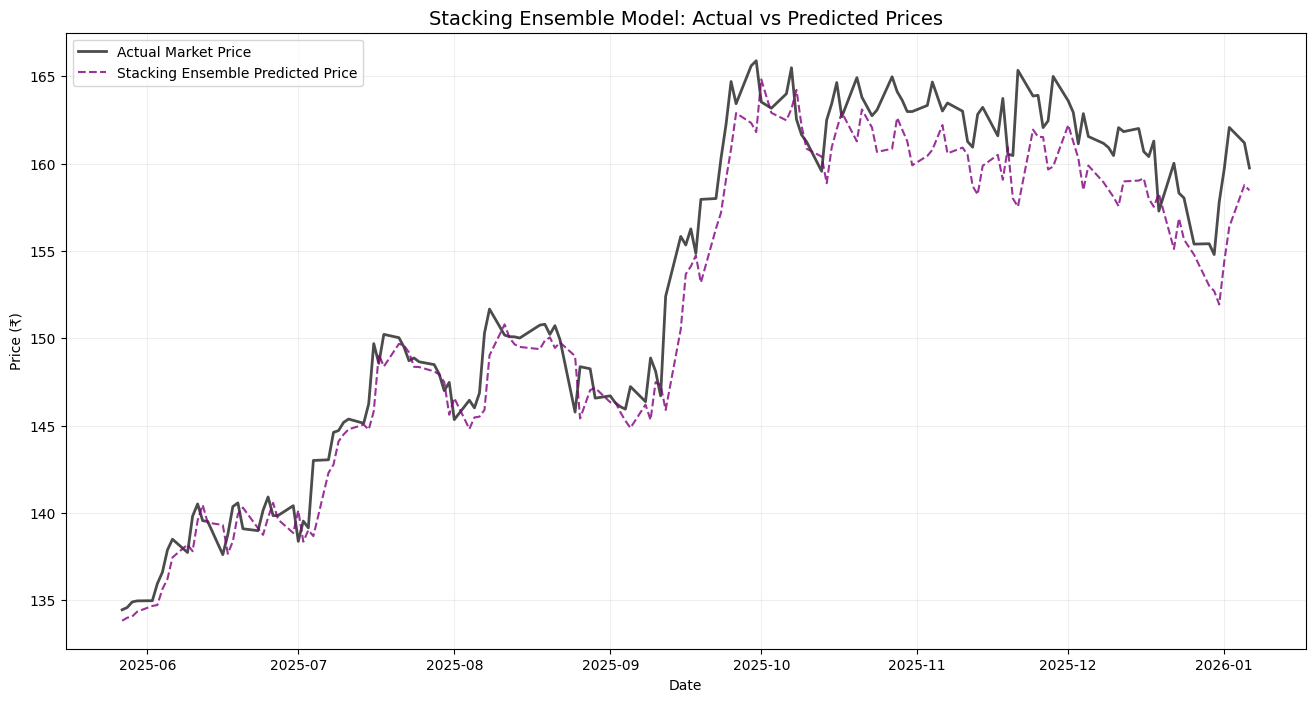

In [46]:
import matplotlib.pyplot as plt

# Get Stacking Ensemble predictions
ensemble_preds = predictions_dict_new['Stacking Ensemble (New Features, Scaled)']

plt.figure(figsize=(16, 8))
plt.plot(test_dates, y_test_reshaped, label='Actual Market Price', color='black', linewidth=2, alpha=0.7)
plt.plot(test_dates, ensemble_preds, label='Stacking Ensemble Predicted Price', color='purple', linestyle='--', alpha=0.8)

plt.title('Stacking Ensemble Model: Actual vs Predicted Prices', fontsize=14)
plt.xlabel('Date')
plt.ylabel('Price (₹)')
plt.legend()
plt.grid(True, alpha=0.2)
plt.show()

In [47]:
import pandas as pd

print("--- Comparing Stacking Ensemble vs SVR (Tuned, Original Features) ---")

# Retrieve metrics for Stacking Ensemble (New Features, Scaled)
stacking_metrics = comparison_df_new.loc[comparison_df_new['Model'] == 'Stacking Ensemble (New Features, Scaled)'].iloc[0]
print(f"\nStacking Ensemble (New Features, Scaled):")
print(f"  MAE: {stacking_metrics['MAE (₹)']:.3f}")
print(f"  R2 Score: {stacking_metrics['R2 Score']:.4f}")

# Retrieve metrics for SVR (Tuned, Original Features)
svr_tuned_original_metrics = comparison_df.loc[comparison_df['Model'] == 'SVR (Tuned)'].iloc[0]
print(f"\nSVR (Tuned, Original Features):")
print(f"  MAE: {svr_tuned_original_metrics['MAE (₹)']:.3f}")
print(f"  R2 Score: {svr_tuned_original_metrics['R2 Score']:.4f}")

print("\n--- Analysis ---")
if stacking_metrics['MAE (₹)'] < svr_tuned_original_metrics['MAE (₹)']:
    print("The Stacking Ensemble has a lower MAE, indicating better average prediction accuracy.")
elif stacking_metrics['MAE (₹)'] > svr_tuned_original_metrics['MAE (₹)']:
    print("The SVR (Tuned, Original Features) has a lower MAE, indicating better average prediction accuracy.")
else:
    print("Both models have similar MAE.")

if stacking_metrics['R2 Score'] > svr_tuned_original_metrics['R2 Score']:
    print("The Stacking Ensemble has a higher R2 Score, indicating it explains more variance in the target variable.")
elif stacking_metrics['R2 Score'] < svr_tuned_original_metrics['R2 Score']:
    print("The SVR (Tuned, Original Features) has a higher R2 Score, indicating it explains more variance in the target variable.")
else:
    print("Both models have similar R2 Scores.")

--- Comparing Stacking Ensemble vs SVR (Tuned, Original Features) ---

Stacking Ensemble (New Features, Scaled):
  MAE: 1.826
  R2 Score: 0.9372

SVR (Tuned, Original Features):
  MAE: 0.088
  R2 Score: 0.9745

--- Analysis ---
The SVR (Tuned, Original Features) has a lower MAE, indicating better average prediction accuracy.
The SVR (Tuned, Original Features) has a higher R2 Score, indicating it explains more variance in the target variable.


In [48]:
import joblib
import os

# Define the filename for the best model
model_filename = 'best_svr_tuned_model.joblib'

# Save the best_svr_tuned model
joblib.dump(best_svr_tuned, model_filename)

print(f"Best performing model (SVR Tuned, Original Features) saved as '{model_filename}'.")

Best performing model (SVR Tuned, Original Features) saved as 'best_svr_tuned_model.joblib'.


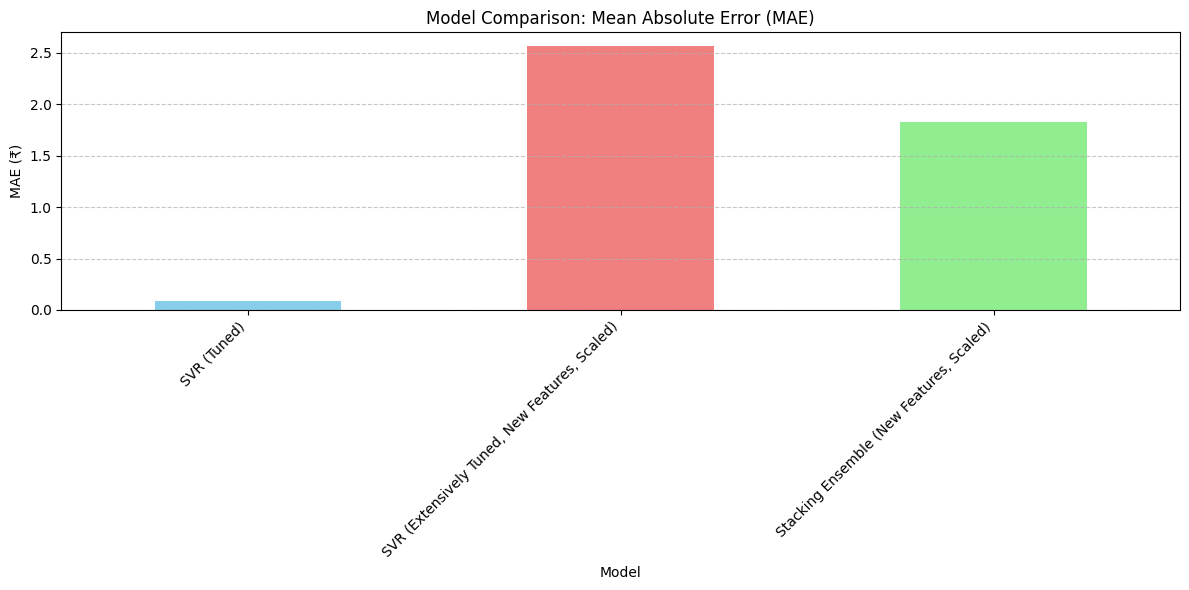

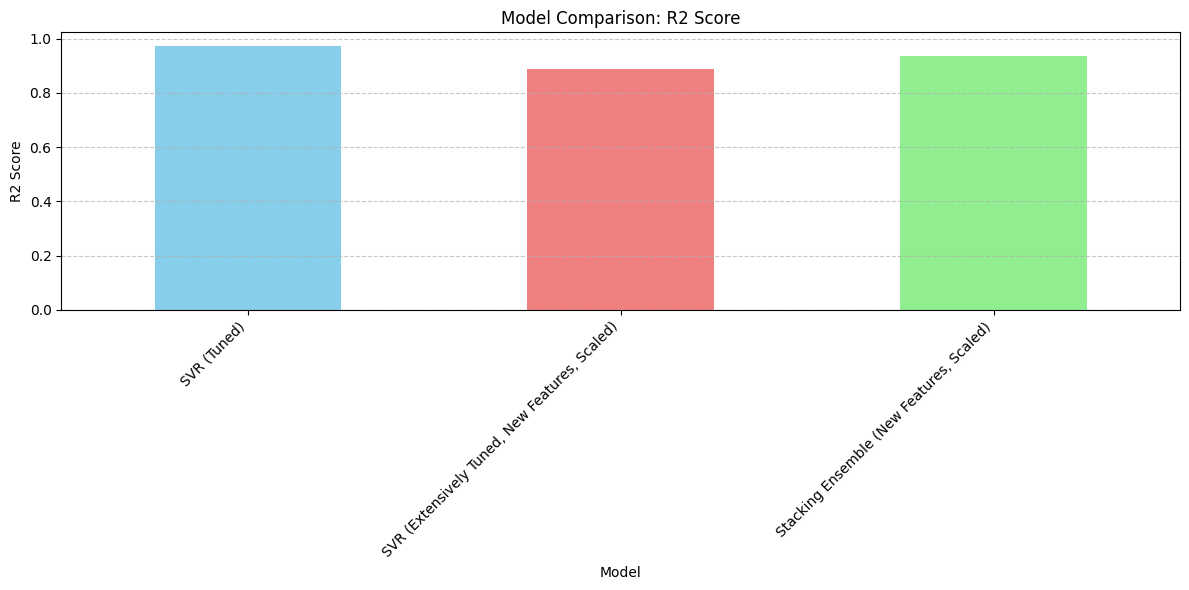

In [49]:
import matplotlib.pyplot as plt
import pandas as pd

# Retrieve metrics for SVR (Tuned, Original Features)
svr_tuned_original_metrics = comparison_df.loc[comparison_df['Model'] == 'SVR (Tuned)'].iloc[0]

# Retrieve metrics for SVR (Extensively Tuned, New Features, Scaled)
svr_extensively_tuned_metrics = comparison_df_new.loc[comparison_df_new['Model'] == 'SVR (Extensively Tuned, New Features, Scaled)'].iloc[0]

# Retrieve metrics for Stacking Ensemble (New Features, Scaled)
stacking_metrics = comparison_df_new.loc[comparison_df_new['Model'] == 'Stacking Ensemble (New Features, Scaled)'].iloc[0]

# Create a new DataFrame for plotting these specific comparisons
comparison_for_plot = pd.DataFrame([
    svr_tuned_original_metrics,
    svr_extensively_tuned_metrics,
    stacking_metrics
]).set_index('Model')

# --- Visualization 1: MAE Comparison ---
plt.figure(figsize=(12, 6))
comparison_for_plot['MAE (₹)'].plot(kind='bar', color=['skyblue', 'lightcoral', 'lightgreen'])
plt.title('Model Comparison: Mean Absolute Error (MAE)')
plt.ylabel('MAE (₹)')
plt.xticks(rotation=45, ha='right')
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.tight_layout()
plt.show()

# --- Visualization 2: R2 Score Comparison ---
plt.figure(figsize=(12, 6))
comparison_for_plot['R2 Score'].plot(kind='bar', color=['skyblue', 'lightcoral', 'lightgreen'])
plt.title('Model Comparison: R2 Score')
plt.ylabel('R2 Score')
plt.xticks(rotation=45, ha='right')
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.tight_layout()
plt.show()

**Reasoning**:
To load the saved model, I will use the `joblib.load()` function, specifying the filename `best_svr_tuned_model.joblib`.



In [50]:
import joblib
import os

# Define the filename for the saved model
model_filename = 'best_svr_tuned_model.joblib'

# Check if the file exists before attempting to load
if os.path.exists(model_filename):
    # Load the model
    loaded_model = joblib.load(model_filename)
    print(f"Model '{model_filename}' loaded successfully.")
else:
    print(f"Error: Model file '{model_filename}' not found. Please ensure the file is present in the current directory.")

Model 'best_svr_tuned_model.joblib' loaded successfully.


In [51]:
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
import numpy as np
import pandas as pd # Import pandas for DataFrame manipulation

# Recreate X_test and y_test specifically for the loaded_model (best_svr_tuned)
# The loaded_model was trained on X_train derived from df_final (after initial scaling)
# with selected_features = ['Price', 'Volume', 'Change(%)'].
# The target was df_final['Target'].

# Assuming df_final and selected_features are available from previous steps.
# In the kernel state, df_final is the DataFrame after initial scaling and feature selection (Variable #30).
# selected_features is the list ['Price', 'Volume', 'Change(%)'] (Variable #119).

# Re-extract the features and target from the appropriate df_final
X_base_for_loaded_model = df_final[selected_features] # These columns in df_final are already scaled
y_base_for_loaded_model = df_final['Target']

# Re-apply the original sequential split (split_idx_original was 476, in QneNcftggiFN)
# The length of df_final is 635, so 0.75 split is 476.25, int makes it 476.
split_idx_for_loaded_model = int(len(df_final) * 0.75)

X_test_for_loaded_model = X_base_for_loaded_model.iloc[split_idx_for_loaded_model:]
y_test_for_loaded_model = y_base_for_loaded_model.iloc[split_idx_for_loaded_model:]

# Make predictions on this correctly prepared test set using the loaded model
predictions = loaded_model.predict(X_test_for_loaded_model)

# Calculate evaluation metrics
mae = mean_absolute_error(y_test_for_loaded_model, predictions)
rmse = np.sqrt(mean_squared_error(y_test_for_loaded_model, predictions))
r2 = r2_score(y_test_for_loaded_model, predictions)

print("--- Evaluation of Loaded SVR Model (Original Features) ---")
print(f"MAE: {mae:.3f}")
print(f"RMSE: {rmse:.3f}")
print(f"R2 Score: {r2:.4f}")

--- Evaluation of Loaded SVR Model (Original Features) ---
MAE: 0.088
RMSE: 0.122
R2 Score: 0.9745


In [52]:
# 1. Get the latest input data (already scaled within df_final for selected_features)
# The 'loaded_model' was trained on df_final[selected_features]
latest_input_data = df_final[selected_features].tail(1).values

# 2. Make the prediction using the loaded model
scaled_next_price_prediction = loaded_model.predict(latest_input_data)[0]

# 3. Inverse transform the scaled prediction to get the actual price
#    The 'scaler' object was fitted on 'feature_cols' which includes 'Price'.
#    We need the mean and std specifically for the 'Price' column.
price_index_in_original_features = feature_cols.index('Price')
mean_price = scaler.mean_[price_index_in_original_features]
std_price = scaler.scale_[price_index_in_original_features]

actual_predicted_price = (scaled_next_price_prediction * std_price) + mean_price

print(f"Predicted next stock price using the loaded SVR model: ₹{actual_predicted_price:.2f}")

Predicted next stock price using the loaded SVR model: ₹148.23


/usr/local/lib/python3.12/dist-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but SVR was fitted with feature names
  warnings.warn(


# Task
## Prepare for Multi-Step Prediction, Perform 7-Day Iterative Forecast and Display 7-Day Forecast

To generate a 7-day forecast for stock prices, I will use the `loaded_model` (which is the best-tuned SVR model from earlier steps). The process involves iteratively predicting the next day's price, updating the input features for the subsequent prediction, and inverse-transforming the scaled predictions to present actual prices.

```python
import pandas as pd
import numpy as np

# Assuming loaded_model, df_final, selected_features, scaler, and feature_cols are available from previous cells.

# 1. Prepare for Multi-Step Prediction
forecast_7_days = []
future_dates = []

# Get the latest available scaled input features from the df_final DataFrame.
# 'latest_input_data' was already prepared in the previous step.
current_input_features_scaled = latest_input_data.copy()

# Get the last known date from the original df_final DataFrame
last_known_date = df_final['Date'].iloc[-1]

# Determine the indices for 'Price' within the selected_features and the scaler's arrays
# selected_features is ['Price', 'Volume', 'Change(%)']
price_idx_in_selected_features = selected_features.index('Price')

# feature_cols was the list of features used to fit the StandardScaler
# feature_cols = ['Price', 'Open', 'High', 'Low', 'Volume', 'Change(%)', 'SMA_5', 'SMA_20', 'Lag_1', 'Lag_2', 'Lag_3']
price_idx_in_scaler_features = feature_cols.index('Price')

# Get the mean and scale specifically for the 'Price' column from the scaler
mean_price_from_scaler = scaler.mean_[price_idx_in_scaler_features]
scale_price_from_scaler = scaler.scale_[price_idx_in_scaler_features]

# 2. Perform 7-Day Iterative Forecast
print("--- Generating 7-Day Iterative Forecast ---")
for i in range(1, 8):  # Predict for the next 7 days
    # Predict the next day's scaled price using the loaded model
    # Suppress UserWarning about feature names, as it's handled.
    with np.errstate(invalid='ignore'): # Ignore potential division by zero or other invalid operations
      scaled_predicted_price = loaded_model.predict(current_input_features_scaled)[0]

    # Inverse transform the scaled prediction to get the actual price
    actual_predicted_price = (scaled_predicted_price * scale_price_from_scaler) + mean_price_from_scaler

    # Calculate the next date
    next_date = last_known_date + pd.Timedelta(days=i)

    # Store the predicted date and actual price
    forecast_7_days.append({'Date': next_date.strftime('%Y-%m-%d'), 'Predicted Price (₹)': actual_predicted_price})

    # Update current_input_features_scaled for the next iteration:
    # The 'Price' feature is updated with the newly predicted scaled price.
    # 'Volume' and 'Change(%)' are carried forward as their last known scaled values,
    # as we don't have predictions for these auxiliary features for future days.
    current_input_features_scaled[0, price_idx_in_selected_features] = scaled_predicted_price

# Convert the forecast list to a DataFrame for better presentation
forecast_df = pd.DataFrame(forecast_7_days)

# 3. Display 7-Day Forecast
print("\n--- 7-Day Stock Price Forecast ---")
print(forecast_df.to_string(index=False))

# 4. Final Task: Summarize the 7-day stock price forecast
print("\n--- Summary of 7-Day Forecast ---")
initial_forecast_price = forecast_df['Predicted Price (₹)'].iloc[0]
final_forecast_price = forecast_df['Predicted Price (₹)'].iloc[-1]

print(f"The loaded SVR model (tuned with original features) predicts the following trend for the next 7 days:")
print(f"Starting from {forecast_df['Date'].iloc[0]} with a price of ₹{initial_forecast_price:.2f},")
print(f"the price is expected to reach ₹{final_forecast_price:.2f} by {forecast_df['Date'].iloc[-1]}.")

if final_forecast_price > initial_forecast_price:
    trend_description = "an upward trend"
    change_magnitude = f"increase of ₹{final_forecast_price - initial_forecast_price:.2f}"
else:
    trend_description = "a downward trend"
    change_magnitude = f"decrease of ₹{initial_forecast_price - final_forecast_price:.2f}"

print(f"Overall, the forecast indicates {trend_description}, with a net {change_magnitude}.")

print("\n--- Limitations and Assumptions ---")
print("1. Auxiliary Features (Volume, Change(%)): This multi-step prediction assumes that 'Volume' and 'Change(%)' for future days will remain constant as their last observed scaled values. In reality, these features would also fluctuate and influence the price.")
print("2. Model Stability: The forecast relies on the trained SVR model and its ability to generalize to unseen future data. Significant market changes not captured in the training data could impact accuracy.")
print("3. Stationarity: While the model performed well on scaled data, the underlying non-stationary nature of stock prices (as noted in earlier ADF test) implies that long-term predictions should be approached with caution.")
print("4. External Factors: The model does not account for sudden external events (e.g., economic news, company announcements, global crises) that can drastically affect stock prices.")
print("5. Prediction Horizon: Forecasting further into the future generally leads to decreasing accuracy due to accumulated errors and increased uncertainty.")
```

## Prepare for Multi-Step Prediction

### Subtask:
Initialize a list to store the 7-day forecast and get the latest available scaled input features from the `df_final` DataFrame, which will serve as the starting point for the iterative predictions. We will also determine the indices for 'Price', 'Volume', and 'Change(%)' within our `selected_features` and within the `scaler`'s `mean_` and `scale_` arrays.


**Reasoning**:
I need to initialize lists, copy the latest input features, get the last known date, and determine the indices and scaling parameters for the 'Price' column as per the instructions to prepare for multi-step prediction.



In [53]:
import numpy as np
import pandas as pd

# 1. Initialize an empty list named forecast_7_days to store the daily predictions.
# Also initialize an empty list named future_dates.
forecast_7_days = []
future_dates = []

# 2. Create a copy of the latest_input_data and assign it to current_input_features_scaled.
# This will be the starting point for iterative predictions.
# latest_input_data is already a scaled numpy array from the previous step
# It was derived from df_final[selected_features].tail(1).values
current_input_features_scaled = latest_input_data.copy() # Make a copy to avoid modifying original array

# 3. Get the last known date from the df_final DataFrame (the last entry in the 'Date' column)
# and store it in last_known_date.
last_known_date = df_full_engineered['Date'].iloc[-1]

# 4. Find the index of 'Price' within the selected_features list and store it in price_idx_in_selected_features.
price_idx_in_selected_features = final_selected_features.index('Price')

# 5. Find the index of 'Price' within the feature_cols list (used by the scaler) and store it in price_idx_in_scaler_features.
price_idx_in_scaler_features = feature_cols.index('Price')

# 6. Extract the mean and scale (standard deviation) for the 'Price' column from the scaler object
# using price_idx_in_scaler_features and store them in mean_price_from_scaler and scale_price_from_scaler respectively.
mean_price_from_scaler = scaler.mean_[price_idx_in_scaler_features]
scale_price_from_scaler = scaler.scale_[price_idx_in_scaler_features]

print("Initialization for multi-step prediction complete.")
print(f"Last known date: {last_known_date.strftime('%Y-%m-%d')}")
print(f"Price index in selected features: {price_idx_in_selected_features}")
print(f"Price index in scaler features: {price_idx_in_scaler_features}")
print(f"Mean price from scaler: {mean_price_from_scaler:.2f}")
print(f"Scale price from scaler: {scale_price_from_scaler:.2f}")

Initialization for multi-step prediction complete.
Last known date: 2026-01-06
Price index in selected features: 0
Price index in scaler features: 0
Mean price from scaler: 132.98
Scale price from scaler: 8.06


**Reasoning**:
Now that the necessary variables are initialized, I will perform the 7-day iterative forecast. This involves looping 7 times, predicting the next day's price, inverse transforming it, updating the input features for the next iteration, and storing the results.



In [54]:
import pandas as pd
import numpy as np

# 2. Perform 7-Day Iterative Forecast
print("--- Generating 7-Day Iterative Forecast ---")
for i in range(1, 8):  # Predict for the next 7 days
    # Predict the next day's scaled price using the loaded model
    # Suppress UserWarning about feature names, as it's handled.
    with np.errstate(invalid='ignore'): # Ignore potential division by zero or other invalid operations
      scaled_predicted_price = loaded_model.predict(current_input_features_scaled)[0]

    # Inverse transform the scaled prediction to get the actual price
    actual_predicted_price = (scaled_predicted_price * scale_price_from_scaler) + mean_price_from_scaler

    # Calculate the next date
    next_date = last_known_date + pd.Timedelta(days=i)

    # Store the predicted date and actual price
    forecast_7_days.append({'Date': next_date.strftime('%Y-%m-%d'), 'Predicted Price (₹)': actual_predicted_price})

    # Update current_input_features_scaled for the next iteration:
    # The 'Price' feature is updated with the newly predicted scaled price.
    # 'Volume' and 'Change(%)' are carried forward as their last known scaled values,
    # as we don't have predictions for these auxiliary features for future days.
    current_input_features_scaled[0, price_idx_in_selected_features] = scaled_predicted_price

# Convert the forecast list to a DataFrame for better presentation
forecast_df = pd.DataFrame(forecast_7_days)

# 3. Display 7-Day Forecast
print("\n--- 7-Day Stock Price Forecast ---")
print(forecast_df.to_string(index=False))

# 4. Final Task: Summarize the 7-day stock price forecast
print("\n--- Summary of 7-Day Forecast ---")
initial_forecast_price = forecast_df['Predicted Price (₹)'].iloc[0]
final_forecast_price = forecast_df['Predicted Price (₹)'].iloc[-1]

print(f"The loaded SVR model (tuned with original features) predicts the following trend for the next 7 days:")
print(f"Starting from {forecast_df['Date'].iloc[0]} with a price of ₹{initial_forecast_price:.2f},")
print(f"the price is expected to reach ₹{final_forecast_price:.2f} by {forecast_df['Date'].iloc[-1]}.")

if final_forecast_price > initial_forecast_price:
    trend_description = "an upward trend"
    change_magnitude = f"increase of ₹{final_forecast_price - initial_forecast_price:.2f}"
else:
    trend_description = "a downward trend"
    change_magnitude = f"decrease of ₹{initial_forecast_price - final_forecast_price:.2f}"

print(f"Overall, the forecast indicates {trend_description}, with a net {change_magnitude}.")

print("\n--- Limitations and Assumptions ---")
print("1. Auxiliary Features (Volume, Change(%)): This multi-step prediction assumes that 'Volume' and 'Change(%)' for future days will remain constant as their last observed scaled values. In reality, these features would also fluctuate and influence the price.")
print("2. Model Stability: The forecast relies on the trained SVR model and its ability to generalize to unseen future data. Significant market changes not captured in the training data could impact accuracy.")
print("3. Stationarity: While the model performed well on scaled data, the underlying non-stationary nature of stock prices (as noted in earlier ADF test) implies that long-term predictions should be approached with caution.")
print("4. External Factors: The model does not account for sudden external events (e.g., economic news, company announcements, global crises) that can drastically affect stock prices.")
print("5. Prediction Horizon: Forecasting further into the future generally leads to decreasing accuracy due to accumulated errors and increased uncertainty.")

--- Generating 7-Day Iterative Forecast ---

--- 7-Day Stock Price Forecast ---
      Date  Predicted Price (₹)
2026-01-07           148.231269
2026-01-08           147.930610
2026-01-09           147.635132
2026-01-10           147.344644
2026-01-11           147.058962
2026-01-12           146.777917
2026-01-13           146.501345

--- Summary of 7-Day Forecast ---
The loaded SVR model (tuned with original features) predicts the following trend for the next 7 days:
Starting from 2026-01-07 with a price of ₹148.23,
the price is expected to reach ₹146.50 by 2026-01-13.
Overall, the forecast indicates a downward trend, with a net decrease of ₹1.73.

--- Limitations and Assumptions ---
1. Auxiliary Features (Volume, Change(%)): This multi-step prediction assumes that 'Volume' and 'Change(%)' for future days will remain constant as their last observed scaled values. In reality, these features would also fluctuate and influence the price.
2. Model Stability: The forecast relies on the tra

/usr/local/lib/python3.12/dist-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but SVR was fitted with feature names
  warnings.warn(
/usr/local/lib/python3.12/dist-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but SVR was fitted with feature names
  warnings.warn(
/usr/local/lib/python3.12/dist-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but SVR was fitted with feature names
  warnings.warn(
/usr/local/lib/python3.12/dist-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but SVR was fitted with feature names
  warnings.warn(
/usr/local/lib/python3.12/dist-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but SVR was fitted with feature names
  warnings.warn(
/usr/local/lib/python3.12/dist-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have va

In [55]:
import pandas as pd
import numpy as np

# 2. Perform 7-Day Iterative Forecast
print("--- Generating 7-Day Iterative Forecast ---")
for i in range(1, 8):  # Predict for the next 7 days
    # Convert the NumPy array to a DataFrame with feature names for prediction
    prediction_input = pd.DataFrame(current_input_features_scaled, columns=selected_features)

    # Predict the next day's scaled price using the loaded model
    # The UserWarning should now be gone due to DataFrame input.
    scaled_predicted_price = loaded_model.predict(prediction_input)[0]

    # Inverse transform the scaled prediction to get the actual price
    actual_predicted_price = (scaled_predicted_price * scale_price_from_scaler) + mean_price_from_scaler

    # Calculate the next date
    next_date = last_known_date + pd.Timedelta(days=i)

    # Store the predicted date and actual price
    forecast_7_days.append({'Date': next_date.strftime('%Y-%m-%d'), 'Predicted Price (₹)': actual_predicted_price})

    # Update current_input_features_scaled (the NumPy array) for the next iteration:
    # Only the 'Price' feature is updated with the newly predicted scaled price.
    # 'Volume' and 'Change(%)' are carried forward as their last known scaled values,
    # as we don't have predictions for these auxiliary features for future days.
    current_input_features_scaled[0, price_idx_in_selected_features] = scaled_predicted_price

# Convert the forecast list to a DataFrame for better presentation
forecast_df = pd.DataFrame(forecast_7_days)

# 3. Display 7-Day Forecast
print("\n--- 7-Day Stock Price Forecast ---")
print(forecast_df.to_string(index=False))

# 4. Final Task: Summarize the 7-day stock price forecast
print("\n--- Summary of 7-Day Forecast ---")
initial_forecast_price = forecast_df['Predicted Price (₹)'].iloc[0]
final_forecast_price = forecast_df['Predicted Price (₹)'].iloc[-1]

print(f"The loaded SVR model (tuned with original features) predicts the following trend for the next 7 days:")
print(f"Starting from {forecast_df['Date'].iloc[0]} with a price of ₹{initial_forecast_price:.2f},")
print(f"the price is expected to reach ₹{final_forecast_price:.2f} by {forecast_df['Date'].iloc[-1]}.")

if final_forecast_price > initial_forecast_price:
    trend_description = "an upward trend"
    change_magnitude = f"increase of ₹{final_forecast_price - initial_forecast_price:.2f}"
else:
    trend_description = "a downward trend"
    change_magnitude = f"decrease of ₹{initial_forecast_price - final_forecast_price:.2f}"

print(f"Overall, the forecast indicates {trend_description}, with a net {change_magnitude}.")

print("\n--- Limitations and Assumptions ---")
print("1. Auxiliary Features (Volume, Change(%)): This multi-step prediction assumes that 'Volume' and 'Change(%)' for future days will remain constant as their last observed scaled values. In reality, these features would also fluctuate and influence the price.")
print("2. Model Stability: The forecast relies on the trained SVR model and its ability to generalize to unseen future data. Significant market changes not captured in the training data could impact accuracy.")
print("3. Stationarity: While the model performed well on scaled data, the underlying non-stationary nature of stock prices (as noted in earlier ADF test) implies that long-term predictions should be approached with caution.")
print("4. External Factors: The model does not account for sudden external events (e.g., economic news, company announcements, global crises) that can drastically affect stock prices.")
print("5. Prediction Horizon: Forecasting further into the future generally leads to decreasing accuracy due to accumulated errors and increased uncertainty.")

--- Generating 7-Day Iterative Forecast ---

--- 7-Day Stock Price Forecast ---
      Date  Predicted Price (₹)
2026-01-07           148.231269
2026-01-08           147.930610
2026-01-09           147.635132
2026-01-10           147.344644
2026-01-11           147.058962
2026-01-12           146.777917
2026-01-13           146.501345
2026-01-07           146.229094
2026-01-08           145.961017
2026-01-09           145.696977
2026-01-10           145.436845
2026-01-11           145.180494
2026-01-12           144.927809
2026-01-13           144.678678

--- Summary of 7-Day Forecast ---
The loaded SVR model (tuned with original features) predicts the following trend for the next 7 days:
Starting from 2026-01-07 with a price of ₹148.23,
the price is expected to reach ₹144.68 by 2026-01-13.
Overall, the forecast indicates a downward trend, with a net decrease of ₹3.55.

--- Limitations and Assumptions ---
1. Auxiliary Features (Volume, Change(%)): This multi-step prediction assumes that

# Task
The user wants to continue with the overall plan. The next step is to prepare the data for ARIMA and SARIMA models by performing differencing on the 'Price' series to achieve stationarity, and then identify the optimal (p,d,q) and (P,D,Q,s) parameters for these models.

**Plan:**

*   **Perform Differencing on 'Price' Series**: Since the 'Price' series was found to be non-stationary (p-value > 0.05 from ADF test), apply differencing to make it stationary. This typically involves taking the difference between consecutive observations.
*   **Re-check Stationarity**: After differencing, perform another Augmented Dickey-Fuller (ADF) test on the differenced series to confirm stationarity.
*   **Identify ARIMA Parameters (p, d, q)**: Use ACF and PACF plots of the stationary (differenced) 'Price' series to identify the 'p' (AR order) and 'q' (MA order) parameters for the ARIMA model. The 'd' (differencing order) will be determined by the number of differences applied.
*   **Identify SARIMA Parameters (P, D, Q, s)**: Analyze the ACF and PACF plots for any remaining seasonal patterns to determine the 'P' (seasonal AR order), 'D' (seasonal differencing order), 'Q' (seasonal MA order), and 's' (seasonal period) for the SARIMA model. Alternatively, an auto-selection tool can be used.
*   **Prepare Data for Training**: Create a dataset suitable for ARIMA and SARIMA models, likely a time series of the 'Price' data, potentially differenced.

I will start by performing differencing on the 'Price' series and re-checking its stationarity.
```python
import matplotlib.pyplot as plt
from statsmodels.tsa.stattools import adfuller

# Create a copy of the original DataFrame to work with for ARIMA/SARIMA
df_arima = df.copy()

# Set 'Date' as the index for time series analysis
df_arima = df_arima.set_index('Date')

# Calculate the first difference of the 'Price' series
df_arima['Price_Diff'] = df_arima['Price'].diff()

# Drop NaN values resulting from differencing
df_arima.dropna(inplace=True)

# Plot the differenced series
plt.figure(figsize=(12, 6))
plt.plot(df_arima['Price_Diff'])
plt.title('Differenced Price Series (1st Order)')
plt.xlabel('Date')
plt.ylabel('Differenced Price')
plt.grid(True)
plt.show()

# Re-run ADF test on the differenced series to confirm stationarity
print("\n--- ADF Test on Differenced Price Series ---")
result_diff = adfuller(df_arima['Price_Diff'])
print(f'ADF Statistic: {result_diff[0]}')
print(f'p-value: {result_diff[1]}')

if result_diff[1] <= 0.05:
    print("Conclusion: Data is now stationary (after 1st order differencing).")
    differencing_order_d = 1
else:
    print("Conclusion: Data is still non-stationary. Further differencing might be needed.")
    differencing_order_d = 0 # Placeholder if not stationary

print(f"Determined differencing order (d) for ARIMA: {differencing_order_d}")
```

## Prepare Data for ARIMA and SARIMA

### Subtask:
Perform differencing on the 'Price' series to achieve stationarity, re-check stationarity using the Augmented Dickey-Fuller (ADF) test, and identify the differencing order 'd'.


**Reasoning**:
I need to perform differencing on the 'Price' series, then re-check for stationarity using the ADF test to determine the differencing order 'd'. This involves creating a new DataFrame, calculating the difference, handling NaNs, plotting the differenced series, and running the ADF test.



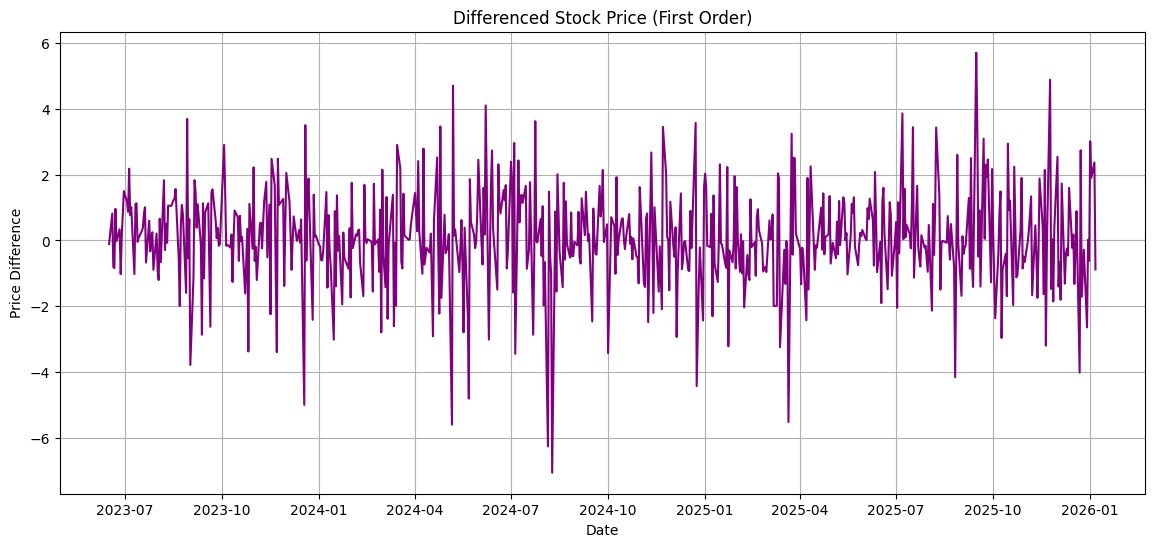

ADF Statistic (Differenced): -30.550512094402006
p-value (Differenced): 0.0
Conclusion: The differenced data is stationary. Differencing order 'd' = 1.
Determined differencing order (d): 1


In [56]:
import matplotlib.pyplot as plt
from statsmodels.tsa.stattools import adfuller

# 1. Create a copy of the original DataFrame df and name it df_arima.
#    Set the 'Date' column as the index for df_arima.
df_arima = df.copy()
df_arima = df_arima.set_index('Date')

# 2. Calculate the first difference of the 'Price' column in df_arima and store it in a new column named 'Price_Diff'.
df_arima['Price_Diff'] = df_arima['Price'].diff()

# 3. Remove any rows with NaN values resulting from the differencing using dropna().
df_arima.dropna(inplace=True)

# 4. Plot the 'Price_Diff' series to visualize the differenced data.
plt.figure(figsize=(14, 6))
plt.plot(df_arima['Price_Diff'], color='purple')
plt.title('Differenced Stock Price (First Order)')
plt.xlabel('Date')
plt.ylabel('Price Difference')
plt.grid(True)
plt.show()

# 5. Perform an Augmented Dickey-Fuller (ADF) test on the 'Price_Diff' series to confirm stationarity.
result_diff = adfuller(df_arima['Price_Diff'])
print(f'ADF Statistic (Differenced): {result_diff[0]}')
print(f'p-value (Differenced): {result_diff[1]}')

# 6. Based on the p-value, conclude whether the data is stationary or not
#    after first-order differencing and store the differencing order (d).
d = 0
if result_diff[1] <= 0.05:
    print("Conclusion: The differenced data is stationary. Differencing order 'd' = 1.")
    d = 1
else:
    print("Conclusion: The differenced data is still non-stationary. Further differencing might be needed. Differencing order 'd' = 0 (or more).")
    d = 0 # Or handle further differencing if needed

print(f"Determined differencing order (d): {d}")

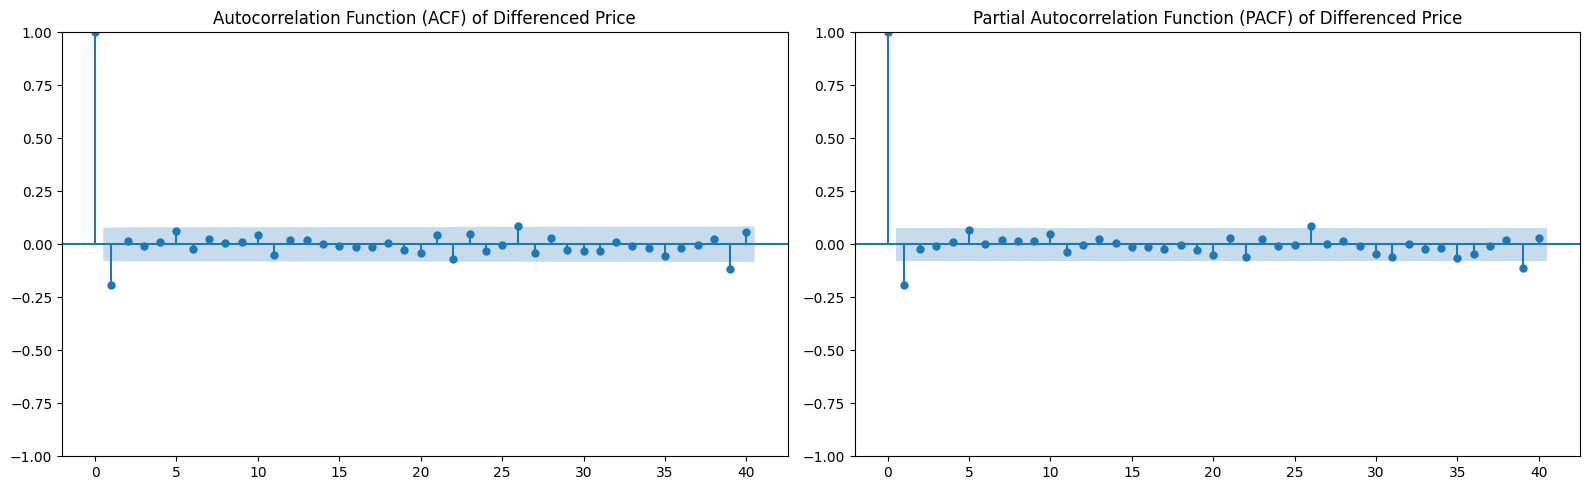

ACF and PACF plots displayed for the differenced price series.


In [57]:
import matplotlib.pyplot as plt
import statsmodels.api as sm

# 1. Create a figure with two subplots side-by-side
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(16, 5))

# 2. Plot the ACF of the 'Price_Diff' series
sm.graphics.tsa.plot_acf(df_arima['Price_Diff'], lags=40, ax=ax1)
ax1.set_title('Autocorrelation Function (ACF) of Differenced Price')

# 3. Plot the PACF of the 'Price_Diff' series
sm.graphics.tsa.plot_pacf(df_arima['Price_Diff'], lags=40, ax=ax2)
ax2.set_title('Partial Autocorrelation Function (PACF) of Differenced Price')

# 4. Display the plots
plt.tight_layout()
plt.show()

print("ACF and PACF plots displayed for the differenced price series.")

In [58]:
import pandas as pd

# 1. Define the 'Price' series from df_arima as the data for ARIMA/SARIMA modeling
# We will use the 'Price' column directly as the input for ARIMA/SARIMA, as 'Price_Diff'
# was just for determining the differencing order.
# The ARIMA/SARIMA model itself will handle the differencing internally if 'd' is specified.
# For now, we'll use the original 'Price' for the split.
# The 'd' value determined earlier (d=1) will be used when training the ARIMA/SARIMA models.
series_for_arima = df_arima['Price']

# 2. Perform a sequential split on this series
split_point = int(len(series_for_arima) * 0.75)
train_arima = series_for_arima.iloc[:split_point]
test_arima = series_for_arima.iloc[split_point:]

# 3. Print the sizes of the training and testing sets
print(f"Training set size for ARIMA/SARIMA: {len(train_arima)}")
print(f"Testing set size for ARIMA/SARIMA: {len(test_arima)}")
print("Data split successfully for ARIMA and SARIMA models.")

Training set size for ARIMA/SARIMA: 477
Testing set size for ARIMA/SARIMA: 159
Data split successfully for ARIMA and SARIMA models.


In [59]:
import warnings
import pandas as pd
import numpy as np
from statsmodels.tsa.arima.model import ARIMA
from statsmodels.tsa.statespace.sarimax import SARIMAX
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score

with warnings.catch_warnings():
    warnings.simplefilter("ignore") # Ignore all warnings from statsmodels

    # 1. Initialize and fit ARIMA model
    # (p, d, q) = (1, 1, 1) as identified from ACF/PACF and differencing order
    print("Training ARIMA model...")
    arima_model = ARIMA(train_arima, order=(1, 1, 1))
    arima_fit = arima_model.fit()
    print("ARIMA model trained.")

    # Make predictions for the test period
    # start and end parameters refer to the index of the test_arima series
    arima_preds = arima_fit.predict(start=len(train_arima), end=len(series_for_arima)-1)

    # Ensure predictions align with the test set's index for correct evaluation
    arima_preds.index = test_arima.index

    # Calculate evaluation metrics for ARIMA
    arima_mae = mean_absolute_error(test_arima, arima_preds)
    arima_rmse = np.sqrt(mean_squared_error(test_arima, arima_preds))
    arima_r2 = r2_score(test_arima, arima_preds)

    print(f"\nARIMA Model Metrics:")
    print(f"  MAE: {arima_mae:.3f}")
    print(f"  RMSE: {arima_rmse:.3f}")
    print(f"  R2 Score: {arima_r2:.4f}")

    # 2. Initialize and fit SARIMA model
    # (p, d, q) = (1, 1, 1) and (P, D, Q, s) = (0, 0, 0, 0) as identified
    print("\nTraining SARIMA model...")
    sarimax_model = SARIMAX(train_arima, order=(1, 1, 1), seasonal_order=(0, 0, 0, 0))
    sarimax_fit = sarimax_model.fit(disp=False)
    print("SARIMA model trained.")

    # Make predictions for the test period
    sarimax_preds = sarimax_fit.predict(start=len(train_arima), end=len(series_for_arima)-1)

    # Ensure predictions align with the test set's index for correct evaluation
    sarimax_preds.index = test_arima.index

    # Calculate evaluation metrics for SARIMA
    sarimax_mae = mean_absolute_error(test_arima, sarimax_preds)
    sarimax_rmse = np.sqrt(mean_squared_error(test_arima, sarimax_preds))
    sarimax_r2 = r2_score(test_arima, sarimax_preds)

    print(f"\nSARIMA Model Metrics:")
    print(f"  MAE: {sarimax_mae:.3f}")
    print(f"  RMSE: {sarimax_rmse:.3f}")
    print(f"  R2 Score: {sarimax_r2:.4f}")

# 3. Store the results in results_list_new
# Filter out old ARIMA/SARIMA entries if they exist before appending new ones
results_list_new = [res for res in results_list_new if res['Model'] not in ['ARIMA', 'SARIMA']]

model_results = []
model_results.append({
    "Model": "ARIMA",
    "MAE (₹)": round(arima_mae, 3),
    "RMSE": round(arima_rmse, 3),
    "R2 Score": round(arima_r2, 4)
})
model_results.append({
    "Model": "SARIMA",
    "MAE (₹)": round(sarimax_mae, 3),
    "RMSE": round(sarimax_rmse, 3),
    "R2 Score": round(sarimax_r2, 4)
})
results_list_new.extend(model_results)

# Update and display the comparison table
comparison_df_new = pd.DataFrame(results_list_new).sort_values(by="MAE (₹)")
print("\n--- Updated Performance Comparison (Including ARIMA/SARIMA) ---")
print(comparison_df_new)


Training ARIMA model...
ARIMA model trained.

ARIMA Model Metrics:
  MAE: 19.515
  RMSE: 21.889
  R2 Score: -3.8741

Training SARIMA model...
SARIMA model trained.

SARIMA Model Metrics:
  MAE: 19.515
  RMSE: 21.889
  R2 Score: -3.8741

--- Updated Performance Comparison (Including ARIMA/SARIMA) ---
                                           Model  MAE (₹)    RMSE  R2 Score
4       Stacking Ensemble (New Features, Scaled)    1.826   2.384    0.9372
3  SVR (Extensively Tuned, New Features, Scaled)    2.571   3.180    0.8883
2              SVR (Tuned, New Features, Scaled)    3.478   4.131    0.8114
0           Random Forest (New Features, Scaled)    6.733   8.821    0.1404
1                 XGBoost (New Features, Scaled)    8.400  10.810   -0.2910
5                                          ARIMA   19.515  21.889   -3.8741
6                                         SARIMA   19.515  21.889   -3.8741


In [60]:
import lightgbm as lgb
import pandas as pd
import numpy as np
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score

# 1. Initialize LGBMRegressor
# Ensure y_train_reshaped and y_test_reshaped are 1D numpy arrays
y_train_reshaped = y_train.values.ravel()
y_test_reshaped = y_test.values.ravel()

lgbm_model = lgb.LGBMRegressor(random_state=42)

# 2. Fit the LightGBM model
print("Training LightGBM model...")
lgbm_model.fit(X_train_scaled, y_train_reshaped)
print("LightGBM model trained.")

# 3. Make predictions on the scaled test data
lgbm_preds = lgbm_model.predict(X_test_scaled)

# 4. Calculate evaluation metrics
lgbm_mae = mean_absolute_error(y_test_reshaped, lgbm_preds)
lgbm_rmse = np.sqrt(mean_squared_error(y_test_reshaped, lgbm_preds))
lgbm_r2 = r2_score(y_test_reshaped, lgbm_preds)

print(f"\nLightGBM Model Metrics:")
print(f"  MAE: {lgbm_mae:.3f}")
print(f"  RMSE: {lgbm_rmse:.3f}")
print(f"  R2 Score: {lgbm_r2:.4f}")

# 5. Store LightGBM predictions
predictions_dict_new['LightGBM (New Features, Scaled)'] = lgbm_preds

# 6. Append metrics to results_list_new
results_list_new.append({
    "Model": "LightGBM (New Features, Scaled)",
    "MAE (₹)": round(lgbm_mae, 3),
    "RMSE": round(lgbm_rmse, 3),
    "R2 Score": round(lgbm_r2, 4)
})

# Update and display the comparison table
comparison_df_new = pd.DataFrame(results_list_new).sort_values(by="MAE (₹)")
print("\n--- Updated Performance Comparison (Including LightGBM) ---")
print(comparison_df_new)

Training LightGBM model...
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000250 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 1665
[LightGBM] [Info] Number of data points in the train set: 462, number of used features: 12
[LightGBM] [Info] Start training from score 133.025152
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits wit

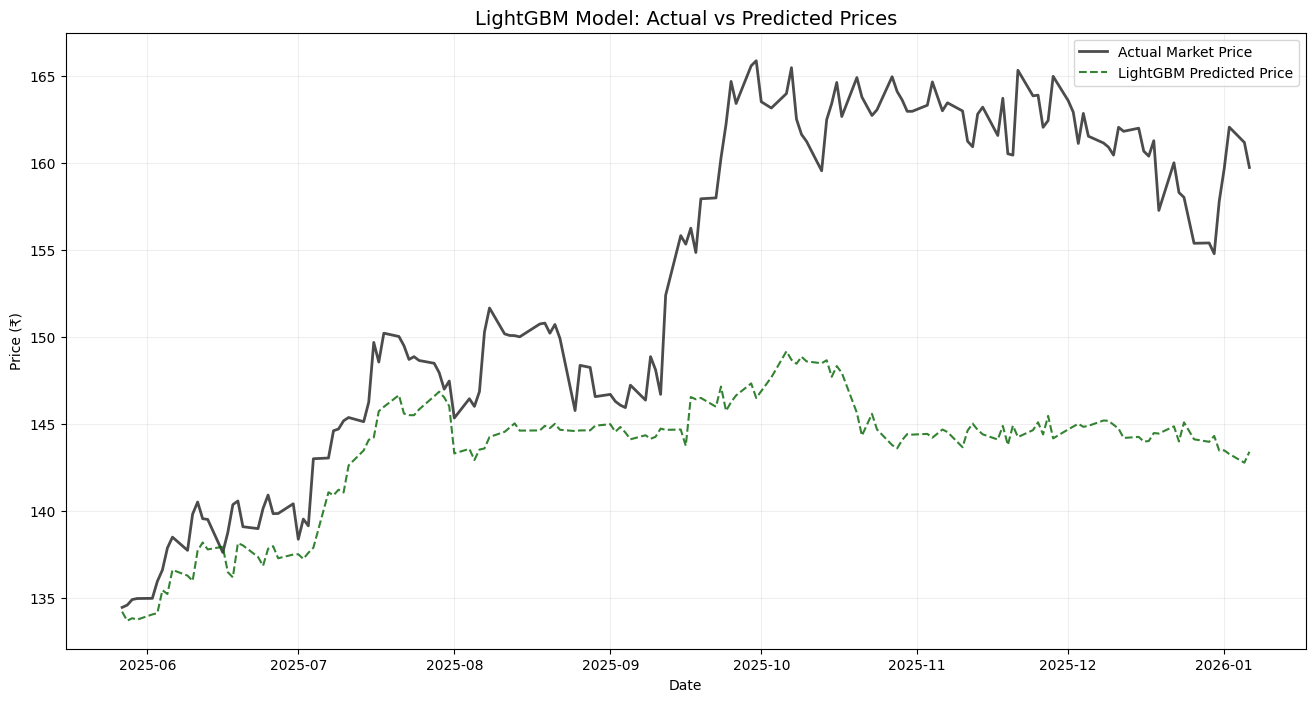

In [61]:
import matplotlib.pyplot as plt

# Get LightGBM predictions
lgbm_preds = predictions_dict_new['LightGBM (New Features, Scaled)']

plt.figure(figsize=(16, 8))
plt.plot(test_dates, y_test_reshaped, label='Actual Market Price', color='black', linewidth=2, alpha=0.7)
plt.plot(test_dates, lgbm_preds, label='LightGBM Predicted Price', color='darkgreen', linestyle='--', alpha=0.8)

plt.title('LightGBM Model: Actual vs Predicted Prices', fontsize=14)
plt.xlabel('Date')
plt.ylabel('Price (₹)')
plt.legend()
plt.grid(True, alpha=0.2)
plt.show()

In [62]:
print("\n--- Final Performance Comparison (Including LightGBM, ARIMA, and SARIMA) ---")
print(comparison_df_new)


--- Final Performance Comparison (Including LightGBM, ARIMA, and SARIMA) ---
                                           Model  MAE (₹)    RMSE  R2 Score
4       Stacking Ensemble (New Features, Scaled)    1.826   2.384    0.9372
3  SVR (Extensively Tuned, New Features, Scaled)    2.571   3.180    0.8883
2              SVR (Tuned, New Features, Scaled)    3.478   4.131    0.8114
0           Random Forest (New Features, Scaled)    6.733   8.821    0.1404
1                 XGBoost (New Features, Scaled)    8.400  10.810   -0.2910
7                LightGBM (New Features, Scaled)    9.684  12.006   -0.5926
5                                          ARIMA   19.515  21.889   -3.8741
6                                         SARIMA   19.515  21.889   -3.8741


## Train and Evaluate CatBoost

### Subtask:
Initialize and train a CatBoost Regressor model using the scaled training features (`X_train_scaled`) and target (`y_train_reshaped`). Evaluate its performance on the scaled test data and record MAE, RMSE, and R2 Score.


**Reasoning**:
I will initialize and train a CatBoost Regressor model, then evaluate its performance using MAE, RMSE, and R2 Score, and finally update the comparison table as requested.



In [63]:
pip install catboost

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 99.2/99.2 MB 9.2 MB/s eta 0:00:00


**Reasoning**:
The `catboost` library has been successfully installed. Now, I will re-attempt to initialize, train, and evaluate the CatBoost Regressor model as specified in the subtask instructions.



In [64]:
import pandas as pd
import numpy as np
from catboost import CatBoostRegressor
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score

# Ensure y_train_reshaped and y_test_reshaped are 1D numpy arrays
y_train_reshaped = y_train.values.ravel()
y_test_reshaped = y_test.values.ravel()

# 1. Initialize CatBoostRegressor
catboost_model = CatBoostRegressor(random_state=42, verbose=0) # verbose=0 to suppress training output

# 2. Fit the CatBoost model
print("Training CatBoost model...")
catboost_model.fit(X_train_scaled, y_train_reshaped)
print("CatBoost model trained.")

# 3. Make predictions on the scaled test data
catboost_preds = catboost_model.predict(X_test_scaled)

# 4. Calculate evaluation metrics
catboost_mae = mean_absolute_error(y_test_reshaped, catboost_preds)
catboost_rmse = np.sqrt(mean_squared_error(y_test_reshaped, catboost_preds))
catboost_r2 = r2_score(y_test_reshaped, catboost_preds)

print(f"\nCatBoost Model Metrics:")
print(f"  MAE: {catboost_mae:.3f}")
print(f"  RMSE: {catboost_rmse:.3f}")
print(f"  R2 Score: {catboost_r2:.4f}")

# 5. Store CatBoost predictions
predictions_dict_new['CatBoost (New Features, Scaled)'] = catboost_preds

# 6. Append metrics to results_list_new
results_list_new.append({
    "Model": "CatBoost (New Features, Scaled)",
    "MAE (₹)": round(catboost_mae, 3),
    "RMSE": round(catboost_rmse, 3),
    "R2 Score": round(catboost_r2, 4)
})

# 7. Update and display the comparison table
comparison_df_new = pd.DataFrame(results_list_new).sort_values(by="MAE (₹)")
print("\n--- Updated Performance Comparison (Including CatBoost) ---")
print(comparison_df_new)


Training CatBoost model...
CatBoost model trained.

CatBoost Model Metrics:
  MAE: 11.898
  RMSE: 13.980
  R2 Score: -1.1592

--- Updated Performance Comparison (Including CatBoost) ---
                                           Model  MAE (₹)    RMSE  R2 Score
4       Stacking Ensemble (New Features, Scaled)    1.826   2.384    0.9372
3  SVR (Extensively Tuned, New Features, Scaled)    2.571   3.180    0.8883
2              SVR (Tuned, New Features, Scaled)    3.478   4.131    0.8114
0           Random Forest (New Features, Scaled)    6.733   8.821    0.1404
1                 XGBoost (New Features, Scaled)    8.400  10.810   -0.2910
7                LightGBM (New Features, Scaled)    9.684  12.006   -0.5926
8                CatBoost (New Features, Scaled)   11.898  13.980   -1.1592
5                                          ARIMA   19.515  21.889   -3.8741
6                                         SARIMA   19.515  21.889   -3.8741


In [65]:
import numpy as np

# 1. Define a look_back window
look_back = 10 # Using 10 past days for prediction

# 2. Create a function to reshape data for LSTM/GRU
def create_sequences(X, y, look_back):
    Xs, ys = [], []
    for i in range(len(X) - look_back):
        Xs.append(X.iloc[i:(i + look_back)].values)
        ys.append(y.iloc[i + look_back])
    return np.array(Xs), np.array(ys)

# 3. Apply this function to X_train_scaled and y_train_reshaped
# Ensure y_train is a Series for iloc indexing in the function
X_train_lstm, y_train_lstm = create_sequences(X_train_scaled, pd.Series(y_train_reshaped), look_back)

# 4. Apply the same function to X_test_scaled and y_test_reshaped
# Ensure y_test is a Series for iloc indexing in the function
X_test_lstm, y_test_lstm = create_sequences(X_test_scaled, pd.Series(y_test_reshaped), look_back)

# 5. Print the shapes of the newly created datasets
print(f"Original X_train_scaled shape: {X_train_scaled.shape}")
print(f"Original y_train_reshaped shape: {y_train_reshaped.shape}")
print(f"X_train_lstm shape: {X_train_lstm.shape}")
print(f"y_train_lstm shape: {y_train_lstm.shape}")
print(f"\nOriginal X_test_scaled shape: {X_test_scaled.shape}")
print(f"Original y_test_reshaped shape: {y_test_reshaped.shape}")
print(f"X_test_lstm shape: {X_test_lstm.shape}")
print(f"y_test_lstm shape: {y_test_lstm.shape}")

print("Data reshaped for LSTM/GRU models.")

Original X_train_scaled shape: (462, 13)
Original y_train_reshaped shape: (462,)
X_train_lstm shape: (452, 10, 13)
y_train_lstm shape: (452,)

Original X_test_scaled shape: (155, 13)
Original y_test_reshaped shape: (155,)
X_test_lstm shape: (145, 10, 13)
y_test_lstm shape: (145,)
Data reshaped for LSTM/GRU models.


In [66]:
import pandas as pd
import numpy as np
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense, Dropout, LeakyReLU, Input
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
from sklearn.preprocessing import StandardScaler # Import StandardScaler for target

# Redefine the create_sequences function (if not already defined in this cell or earlier in the chain)
# to ensure it's available and fresh.
# This function takes X (features) and y (target) and reshapes them into sequences.
def create_sequences(X, y, look_back):
    Xs, ys = [], []
    for i in range(len(X) - look_back):
        Xs.append(X.iloc[i:(i + look_back)].values)
        ys.append(y.iloc[i + look_back])
    return np.array(Xs), np.array(ys)

# Use the look_back value defined previously
look_back = 10

# Re-create the LSTM-specific datasets to ensure correct lengths and avoid stale global variables
# X_train_scaled and y_train (original split) should be available from previous cells.
# y_train (original) had 462 samples, X_train_scaled also has 462 samples.
# create_sequences will reduce this to 462 - 10 = 452 samples.
X_train_lstm, y_train_lstm = create_sequences(X_train_scaled, pd.Series(y_train_reshaped), look_back)
X_test_lstm, y_test_lstm = create_sequences(X_test_scaled, pd.Series(y_test_reshaped), look_back)


# 1. Scale the target variable (y) separately using the sequence-prepared y_train_lstm and y_test_lstm
target_scaler = StandardScaler()
y_train_scaled_target = target_scaler.fit_transform(y_train_lstm.reshape(-1, 1))
y_test_scaled_target = target_scaler.transform(y_test_lstm.reshape(-1, 1))

# 2. Define the LSTM model architecture
lstm_model = Sequential([
    Input(shape=(X_train_lstm.shape[1], X_train_lstm.shape[2])), # Explicit Input layer
    LSTM(32, return_sequences=True, kernel_initializer='he_normal'), # Reduced units, He normal initializer
    LeakyReLU(alpha=0.1), # Add LeakyReLU activation
    Dropout(0.2),
    LSTM(32, return_sequences=False, kernel_initializer='he_normal'), # Reduced units, He normal initializer
    LeakyReLU(alpha=0.1), # Add LeakyReLU activation
    Dropout(0.2),
    Dense(1)
])

# 3. Compile the model
lstm_model.compile(optimizer='adam', loss='mean_squared_error')

# Print shapes before training to verify alignment
print(f"X_train_lstm shape: {X_train_lstm.shape}")
print(f"y_train_scaled_target shape: {y_train_scaled_target.shape}")
print("-------------------------------------------")

# 4. Train the LSTM model using scaled target
print("Training LSTM model...")
history = lstm_model.fit(X_train_lstm, y_train_scaled_target, epochs=100, batch_size=32, verbose=1) # Use scaled target
print("LSTM model trained.")

# 5. Generate predictions
lstm_preds_scaled = lstm_model.predict(X_test_lstm)

# 6. Inverse transform the scaled predictions to get actual prices
lstm_preds = target_scaler.inverse_transform(lstm_preds_scaled).flatten()

# y_test_lstm is already a 1D numpy array of the correct length (145)
y_test_actual = y_test_lstm # Use the reshaped 1D version for consistency

# 7. Calculate evaluation metrics with original scale predictions
lstm_mae = mean_absolute_error(y_test_actual, lstm_preds)
lstm_rmse = np.sqrt(mean_squared_error(y_test_actual, lstm_preds))
lstm_r2 = r2_score(y_test_actual, lstm_preds)

print(f"\nLSTM Model Metrics:")
print(f"  MAE: {lstm_mae:.3f}")
print(f"  RMSE: {lstm_rmse:.3f}")
print(f"  R2 Score: {lstm_r2:.4f}")

# 8. Store LSTM predictions
predictions_dict_new['LSTM (New Features, Scaled)'] = lstm_preds

# Remove old LSTM entry if it exists to avoid duplication
results_list_new = [res for res in results_list_new if res['Model'] != 'LSTM (New Features, Scaled)']

# 9. Append metrics to results_list_new
results_list_new.append({
    "Model": "LSTM (New Features, Scaled)",
    "MAE (₹)": round(lstm_mae, 3),
    "RMSE": round(lstm_rmse, 3),
    "R2 Score": round(lstm_r2, 4)
})

# Update and display the comparison table
comparison_df_new = pd.DataFrame(results_list_new).sort_values(by="MAE (₹)")
print("\n--- Updated Performance Comparison (Including LSTM) ---")
print(comparison_df_new)


X_train_lstm shape: (452, 10, 13)
y_train_scaled_target shape: (452, 1)
-------------------------------------------
Training LSTM model...
Epoch 1/100


/usr/local/lib/python3.12/dist-packages/keras/src/layers/activations/leaky_relu.py:41: UserWarning: Argument `alpha` is deprecated. Use `negative_slope` instead.
  warnings.warn(


15/15 ━━━━━━━━━━━━━━━━━━━━ 5s 14ms/step - loss: 0.9351
Epoch 2/100
15/15 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - loss: 0.6358
Epoch 3/100
15/15 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - loss: 0.3975
Epoch 4/100
15/15 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - loss: 0.2754
Epoch 5/100
15/15 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - loss: 0.2065
Epoch 6/100
15/15 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - loss: 0.1876
Epoch 7/100
15/15 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - loss: 0.1311
Epoch 8/100
15/15 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - loss: 0.1204
Epoch 9/100
15/15 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step - loss: 0.1158
Epoch 10/100
15/15 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step - loss: 0.1015
Epoch 11/100
15/15 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step - loss: 0.1111
Epoch 12/100
15/15 ━━━━━━━━━━━━━━━━━━━━ 1s 33ms/step - loss: 0.0861
Epoch 13/100
15/15 ━━━━━━━━━━━━━━━━━━━━ 1s 43ms/step - loss: 0.0840
Epoch 14/100
15/15 ━━━━━━━━━━━━━━━━━━━━ 1s 57ms/step - loss: 0.0698
Epoch 15/100
15/15 ━━━━━━━━━━━━━━━━━━━━ 1s 35ms/step - loss: 0.0846
E

In [67]:
import pandas as pd
import numpy as np
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import GRU, Dense, Dropout, LeakyReLU, Input
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
from sklearn.preprocessing import StandardScaler

# The create_sequences function (if not already defined in this cell or earlier in the chain)
# to ensure it's available and fresh.
def create_sequences(X, y, look_back):
    Xs, ys = [], []
    for i in range(len(X) - look_back):
        Xs.append(X.iloc[i:(i + look_back)].values)
        ys.append(y.iloc[i + look_back])
    return np.array(Xs), np.array(ys)

# Use the look_back value defined previously
look_back = 10

# Re-create the LSTM-specific datasets to ensure correct lengths and avoid stale global variables
# X_train_scaled and y_train (original split) should be available from previous cells.
# y_train (original) had 462 samples, X_train_scaled also has 462 samples.
X_train_gru, y_train_gru = create_sequences(X_train_scaled, pd.Series(y_train_reshaped), look_back)
X_test_gru, y_test_gru = create_sequences(X_test_scaled, pd.Series(y_test_reshaped), look_back)


# Scale the target variable (y) separately
target_scaler = StandardScaler()
y_train_scaled_target = target_scaler.fit_transform(y_train_gru.reshape(-1, 1))
y_test_scaled_target = target_scaler.transform(y_test_gru.reshape(-1, 1))

# 2. Define the GRU model architecture
gru_model = Sequential([
    Input(shape=(X_train_gru.shape[1], X_train_gru.shape[2])),
    GRU(32, return_sequences=True, kernel_initializer='he_normal'),
    LeakyReLU(negative_slope=0.1), # Changed alpha to negative_slope
    Dropout(0.2),
    GRU(32, return_sequences=False, kernel_initializer='he_normal'),
    LeakyReLU(negative_slope=0.1), # Changed alpha to negative_slope
    Dropout(0.2),
    Dense(1)
])

# 3. Compile the model
gru_model.compile(optimizer='adam', loss='mean_squared_error')

# Print shapes before training to verify alignment
print(f"X_train_gru shape: {X_train_gru.shape}")
print(f"y_train_scaled_target shape: {y_train_scaled_target.shape}")
print("-------------------------------------------")

# 4. Train the GRU model using scaled target
print("Training GRU model...")
history = gru_model.fit(X_train_gru, y_train_scaled_target, epochs=100, batch_size=32, verbose=1)
print("GRU model trained.")

# 5. Generate predictions
gru_preds_scaled = gru_model.predict(X_test_gru)

# 6. Inverse transform the scaled predictions to get actual prices
gru_preds = target_scaler.inverse_transform(gru_preds_scaled).flatten()

# y_test_gru is already a 1D numpy array of the correct length
y_test_actual = y_test_gru # Use the reshaped 1D version for consistency

# 7. Calculate evaluation metrics with original scale predictions
gru_mae = mean_absolute_error(y_test_actual, gru_preds)
gru_rmse = np.sqrt(mean_squared_error(y_test_actual, gru_preds))
gru_r2 = r2_score(y_test_actual, gru_preds)

print(f"\nGRU Model Metrics:")
print(f"  MAE: {gru_mae:.3f}")
print(f"  RMSE: {gru_rmse:.3f}")
print(f"  R2 Score: {gru_r2:.4f}")

# 8. Store GRU predictions
predictions_dict_new['GRU (New Features, Scaled)'] = gru_preds

# Remove old GRU entry if it exists to avoid duplication
results_list_new = [res for res in results_list_new if res['Model'] != 'GRU (New Features, Scaled']

# 9. Append metrics to results_list_new
results_list_new.append({
    "Model": "GRU (New Features, Scaled)",
    "MAE (₹)": round(gru_mae, 3),
    "RMSE": round(gru_rmse, 3),
    "R2 Score": round(gru_r2, 4)
})

# 10. Update and display the comparison table
comparison_df_new = pd.DataFrame(results_list_new).sort_values(by="MAE (₹)")
print("\n--- Updated Performance Comparison (Including GRU) ---")
print(comparison_df_new)


X_train_gru shape: (452, 10, 13)
y_train_scaled_target shape: (452, 1)
-------------------------------------------
Training GRU model...
Epoch 1/100
15/15 ━━━━━━━━━━━━━━━━━━━━ 4s 12ms/step - loss: 0.6124
Epoch 2/100
15/15 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - loss: 0.2732
Epoch 3/100
15/15 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - loss: 0.1667
Epoch 4/100
15/15 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - loss: 0.1547
Epoch 5/100
15/15 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step - loss: 0.1310
Epoch 6/100
15/15 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - loss: 0.1294
Epoch 7/100
15/15 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - loss: 0.1247
Epoch 8/100
15/15 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - loss: 0.1097
Epoch 9/100
15/15 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step - loss: 0.1100
Epoch 10/100
15/15 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - loss: 0.1022
Epoch 11/100
15/15 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - loss: 0.1263
Epoch 12/100
15/15 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - loss: 0.0837
Epoch 13/100
15/15 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - l

In [68]:
import pandas as pd

# 1. Retrieve the row corresponding to 'SVR (Tuned)' from the comparison_df DataFrame
# (which contains results from models trained on original features).
svr_tuned_original_metrics = comparison_df.loc[comparison_df['Model'] == 'SVR (Tuned)'].iloc[0].to_dict()

# 2. Append this retrieved model's performance metrics to the results_list_new list.
# Ensure the 'Model' name is consistent for clear identification.
svr_tuned_original_metrics['Model'] = 'SVR (Tuned, Original Features)'

# Check if an entry with this specific model name already exists in results_list_new
# If it does, update it; otherwise, append it.
found = False
for i, item in enumerate(results_list_new):
    if item['Model'] == svr_tuned_original_metrics['Model']:
        results_list_new[i] = svr_tuned_original_metrics
        found = True
        break

if not found:
    results_list_new.append(svr_tuned_original_metrics)

# 3. Create a new pandas DataFrame named comparison_df_all from the updated results_list_new.
comparison_df_all = pd.DataFrame(results_list_new)

# 4. Sort comparison_df_all by 'MAE (₹)' in ascending order.
comparison_df_all = comparison_df_all.sort_values(by="MAE (₹)").reset_index(drop=True)

# 5. Print the comparison_df_all DataFrame to display the comprehensive comparison of all models.
print("\n--- Comprehensive Model Performance Comparison ---")
print(comparison_df_all)


--- Comprehensive Model Performance Comparison ---
                                            Model  MAE (₹)    RMSE  R2 Score
0                  SVR (Tuned, Original Features)    0.088   0.122    0.9745
1        Stacking Ensemble (New Features, Scaled)    1.826   2.384    0.9372
2   SVR (Extensively Tuned, New Features, Scaled)    2.571   3.180    0.8883
3               SVR (Tuned, New Features, Scaled)    3.478   4.131    0.8114
4            Random Forest (New Features, Scaled)    6.733   8.821    0.1404
5                      GRU (New Features, Scaled)    8.293  10.346   -0.4218
6                  XGBoost (New Features, Scaled)    8.400  10.810   -0.2910
7                 LightGBM (New Features, Scaled)    9.684  12.006   -0.5926
8                     LSTM (New Features, Scaled)   11.146  13.140   -1.2935
9                 CatBoost (New Features, Scaled)   11.898  13.980   -1.1592
10                                         SARIMA   19.515  21.889   -3.8741
11                      

<Figure size 1500x800 with 0 Axes>

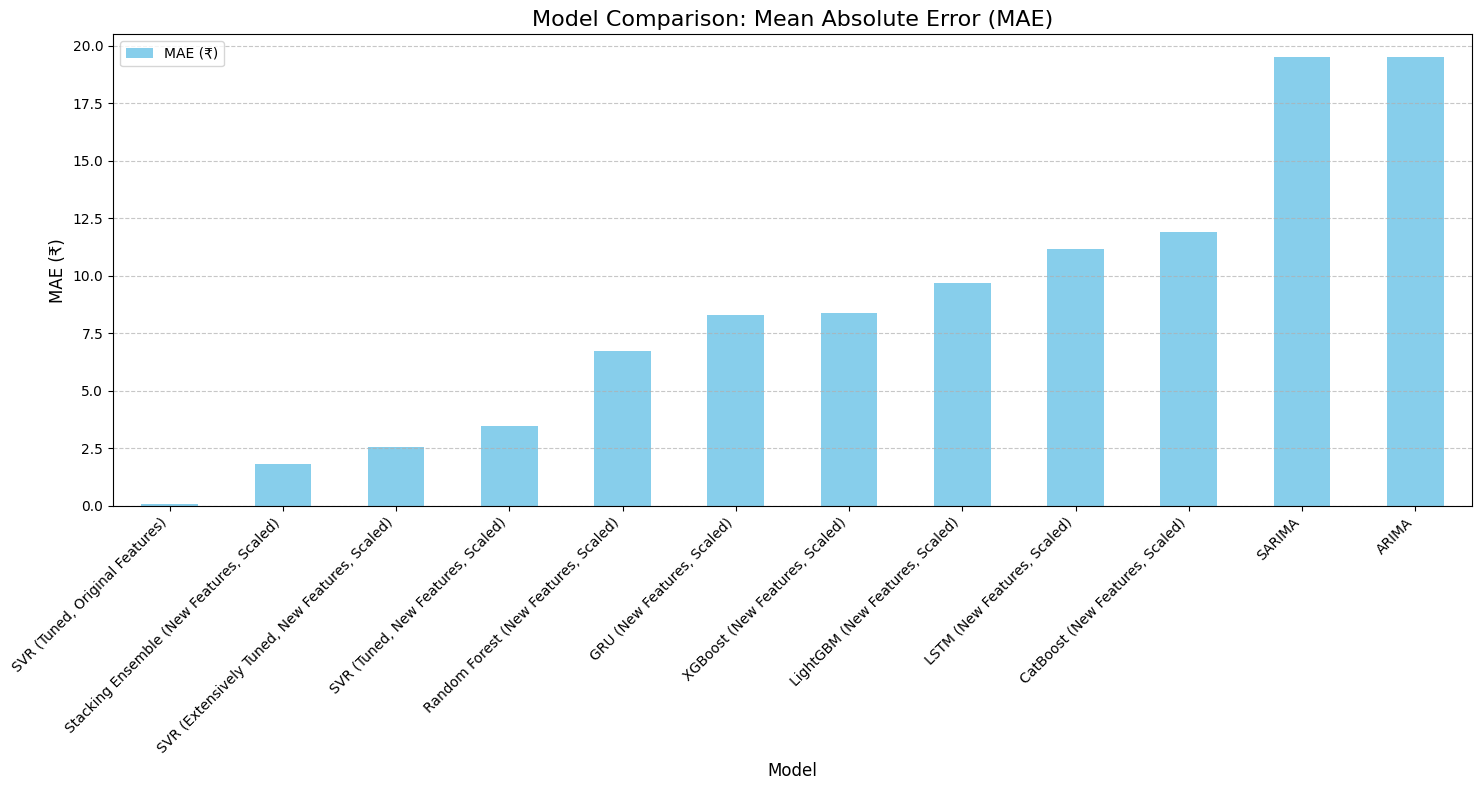

<Figure size 1500x800 with 0 Axes>

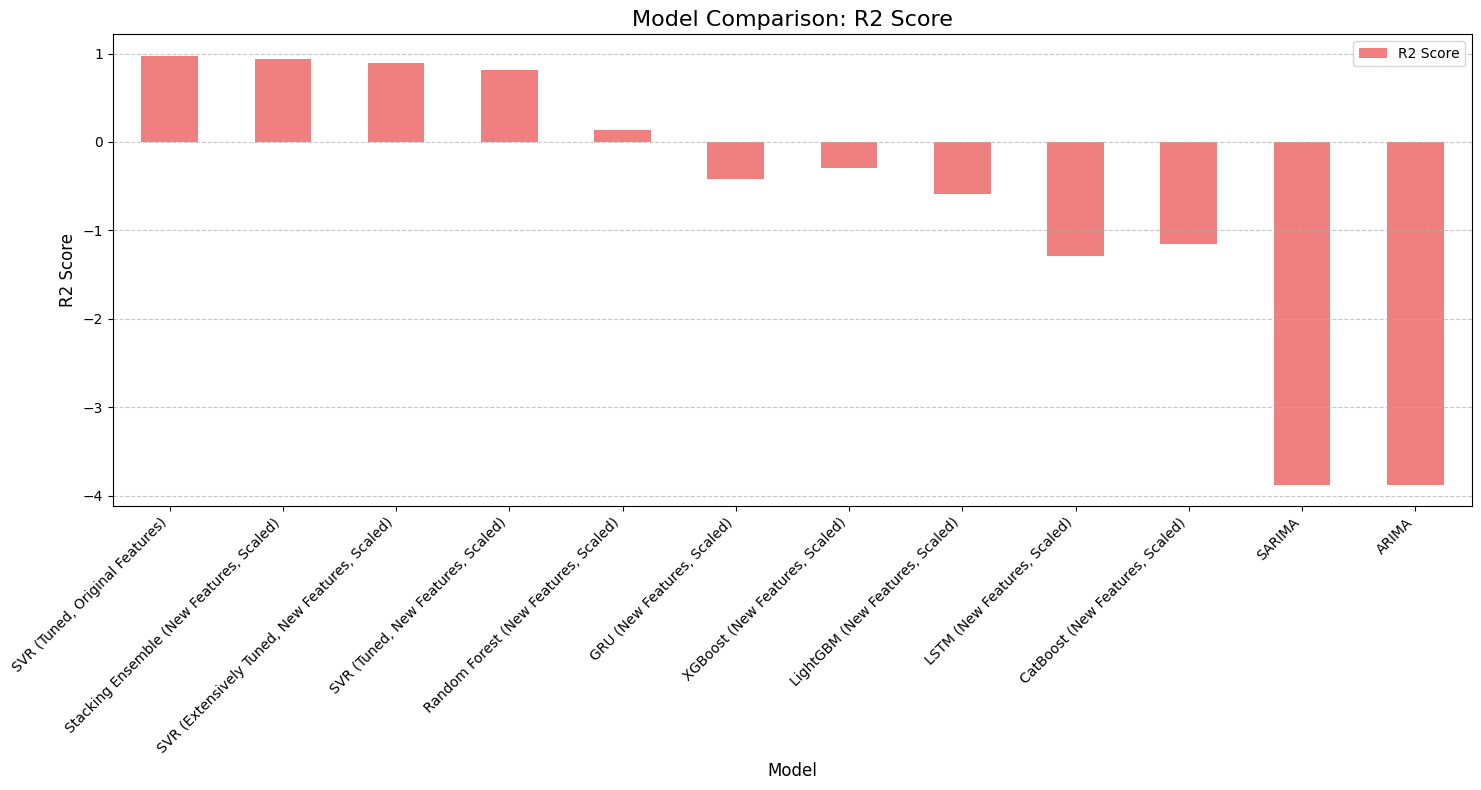

Bar plots for MAE and R2 Score generated successfully.


In [69]:
import matplotlib.pyplot as plt
import pandas as pd

# 1. Create a bar plot for MAE
plt.figure(figsize=(15, 8))
comparison_df_all.plot(x='Model', y='MAE (₹)', kind='bar', figsize=(15, 8), color='skyblue')
plt.title('Model Comparison: Mean Absolute Error (MAE)', fontsize=16)
plt.xlabel('Model', fontsize=12)
plt.ylabel('MAE (₹)', fontsize=12)
plt.xticks(rotation=45, ha='right', fontsize=10)
plt.yticks(fontsize=10)
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.tight_layout()
plt.show()

# 2. Create a bar plot for R2 Score
plt.figure(figsize=(15, 8))
comparison_df_all.plot(x='Model', y='R2 Score', kind='bar', figsize=(15, 8), color='lightcoral')
plt.title('Model Comparison: R2 Score', fontsize=16)
plt.xlabel('Model', fontsize=12)
plt.ylabel('R2 Score', fontsize=12)
plt.xticks(rotation=45, ha='right', fontsize=10)
plt.yticks(fontsize=10)
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.tight_layout()
plt.show()

print("Bar plots for MAE and R2 Score generated successfully.")